# Miller age

In [1]:
ood_seed = 2

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip adjacent cells', '18.0'), 777)


Removed datapoint: 777

train         5293
validation    1335
ood            777
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 100453.52it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1052698.66it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 246.24it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<19:01,  2.86s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<19:01,  2.86s/it, v_num=1, recon=1.26e+3, r2_mean=0.0573, adv_loss=3.4, acc_pert=0.353, acc_integration_donor=0.145]

Epoch 2/400:   0%|          | 1/400 [00:02<19:01,  2.86s/it, v_num=1, recon=1.26e+3, r2_mean=0.0573, adv_loss=3.4, acc_pert=0.353, acc_integration_donor=0.145]

Epoch 2/400:   0%|          | 2/400 [00:05<17:03,  2.57s/it, v_num=1, recon=1.26e+3, r2_mean=0.0573, adv_loss=3.4, acc_pert=0.353, acc_integration_donor=0.145]

Epoch 2/400:   0%|          | 2/400 [00:05<17:03,  2.57s/it, v_num=1, recon=1.07e+3, r2_mean=0.273, adv_loss=2.99, acc_pert=0.468, acc_integration_donor=0.25] 

Epoch 3/400:   0%|          | 2/400 [00:05<17:03,  2.57s/it, v_num=1, recon=1.07e+3, r2_mean=0.273, adv_loss=2.99, acc_pert=0.468, acc_integration_donor=0.25]

Epoch 3/400:   1%|          | 3/400 [00:07<16:22,  2.47s/it, v_num=1, recon=1.07e+3, r2_mean=0.273, adv_loss=2.99, acc_pert=0.468, acc_integration_donor=0.25]

Epoch 3/400:   1%|          | 3/400 [00:07<16:22,  2.47s/it, v_num=1, recon=987, r2_mean=0.37, adv_loss=2.69, acc_pert=0.491, acc_integration_donor=0.384]    

Epoch 4/400:   1%|          | 3/400 [00:07<16:22,  2.47s/it, v_num=1, recon=987, r2_mean=0.37, adv_loss=2.69, acc_pert=0.491, acc_integration_donor=0.384]

Epoch 4/400:   1%|          | 4/400 [00:09<16:02,  2.43s/it, v_num=1, recon=987, r2_mean=0.37, adv_loss=2.69, acc_pert=0.491, acc_integration_donor=0.384]

Epoch 4/400:   1%|          | 4/400 [00:09<16:02,  2.43s/it, v_num=1, recon=950, r2_mean=0.422, adv_loss=2.53, acc_pert=0.494, acc_integration_donor=0.45]

Epoch 5/400:   1%|          | 4/400 [00:09<16:02,  2.43s/it, v_num=1, recon=950, r2_mean=0.422, adv_loss=2.53, acc_pert=0.494, acc_integration_donor=0.45]

Epoch 5/400:   1%|▏         | 5/400 [00:12<15:45,  2.39s/it, v_num=1, recon=950, r2_mean=0.422, adv_loss=2.53, acc_pert=0.494, acc_integration_donor=0.45]

Epoch 5/400:   1%|▏         | 5/400 [00:12<15:45,  2.39s/it, v_num=1, recon=929, r2_mean=0.452, adv_loss=2.42, acc_pert=0.504, acc_integration_donor=0.485]

Epoch 6/400:   1%|▏         | 5/400 [00:12<15:45,  2.39s/it, v_num=1, recon=929, r2_mean=0.452, adv_loss=2.42, acc_pert=0.504, acc_integration_donor=0.485]

Epoch 6/400:   2%|▏         | 6/400 [00:14<15:44,  2.40s/it, v_num=1, recon=929, r2_mean=0.452, adv_loss=2.42, acc_pert=0.504, acc_integration_donor=0.485]

Epoch 6/400:   2%|▏         | 6/400 [00:14<15:44,  2.40s/it, v_num=1, recon=913, r2_mean=0.463, adv_loss=2.36, acc_pert=0.51, acc_integration_donor=0.492] 

Epoch 7/400:   2%|▏         | 6/400 [00:14<15:44,  2.40s/it, v_num=1, recon=913, r2_mean=0.463, adv_loss=2.36, acc_pert=0.51, acc_integration_donor=0.492]

Epoch 7/400:   2%|▏         | 7/400 [00:17<17:00,  2.60s/it, v_num=1, recon=913, r2_mean=0.463, adv_loss=2.36, acc_pert=0.51, acc_integration_donor=0.492]

Epoch 7/400:   2%|▏         | 7/400 [00:17<17:00,  2.60s/it, v_num=1, recon=905, r2_mean=0.47, adv_loss=2.3, acc_pert=0.526, acc_integration_donor=0.497] 

Epoch 8/400:   2%|▏         | 7/400 [00:17<17:00,  2.60s/it, v_num=1, recon=905, r2_mean=0.47, adv_loss=2.3, acc_pert=0.526, acc_integration_donor=0.497]

Epoch 8/400:   2%|▏         | 8/400 [00:20<16:29,  2.52s/it, v_num=1, recon=905, r2_mean=0.47, adv_loss=2.3, acc_pert=0.526, acc_integration_donor=0.497]

Epoch 8/400:   2%|▏         | 8/400 [00:20<16:29,  2.52s/it, v_num=1, recon=897, r2_mean=0.482, adv_loss=2.25, acc_pert=0.541, acc_integration_donor=0.501]

Epoch 9/400:   2%|▏         | 8/400 [00:20<16:29,  2.52s/it, v_num=1, recon=897, r2_mean=0.482, adv_loss=2.25, acc_pert=0.541, acc_integration_donor=0.501]

Epoch 9/400:   2%|▏         | 9/400 [00:22<16:12,  2.49s/it, v_num=1, recon=897, r2_mean=0.482, adv_loss=2.25, acc_pert=0.541, acc_integration_donor=0.501]

Epoch 9/400:   2%|▏         | 9/400 [00:22<16:12,  2.49s/it, v_num=1, recon=890, r2_mean=0.478, adv_loss=2.24, acc_pert=0.55, acc_integration_donor=0.496] 

Epoch 10/400:   2%|▏         | 9/400 [00:22<16:12,  2.49s/it, v_num=1, recon=890, r2_mean=0.478, adv_loss=2.24, acc_pert=0.55, acc_integration_donor=0.496]


disnt_basal = 0.5170717941710419

disnt_after = 0.9611927129563288

val_r2_mean = 0.5029720643704588

val_r2_var = 0.1865550855343992


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:32<31:38,  4.87s/it, v_num=1, recon=890, r2_mean=0.478, adv_loss=2.24, acc_pert=0.55, acc_integration_donor=0.496]

Epoch 10/400:   2%|▎         | 10/400 [00:32<31:38,  4.87s/it, v_num=1, recon=888, r2_mean=0.496, adv_loss=2.22, acc_pert=0.554, acc_integration_donor=0.487, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:32<31:38,  4.87s/it, v_num=1, recon=888, r2_mean=0.496, adv_loss=2.22, acc_pert=0.554, acc_integration_donor=0.487, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:34<26:29,  4.09s/it, v_num=1, recon=888, r2_mean=0.496, adv_loss=2.22, acc_pert=0.554, acc_integration_donor=0.487, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:34<26:29,  4.09s/it, v_num=1, recon=881, r2_mean=0.498, adv_loss=2.21, acc_pert=0.548, acc_integration_donor=0.483, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:34<26:29,  4.09s/it, v_num=1, recon=881, r2_mean=0.498, adv_loss=2.21, acc_pert=0.548, acc_integration_donor=0.483, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:37<23:23,  3.62s/it, v_num=1, recon=881, r2_mean=0.498, adv_loss=2.21, acc_pert=0.548, acc_integration_donor=0.483, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:37<23:23,  3.62s/it, v_num=1, recon=878, r2_mean=0.507, adv_loss=2.2, acc_pert=0.557, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:37<23:23,  3.62s/it, v_num=1, recon=878, r2_mean=0.507, adv_loss=2.2, acc_pert=0.557, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:39<20:47,  3.22s/it, v_num=1, recon=878, r2_mean=0.507, adv_loss=2.2, acc_pert=0.557, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:39<20:47,  3.22s/it, v_num=1, recon=874, r2_mean=0.511, adv_loss=2.21, acc_pert=0.548, acc_integration_donor=0.48, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:39<20:47,  3.22s/it, v_num=1, recon=874, r2_mean=0.511, adv_loss=2.21, acc_pert=0.548, acc_integration_donor=0.48, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:42<18:58,  2.95s/it, v_num=1, recon=874, r2_mean=0.511, adv_loss=2.21, acc_pert=0.548, acc_integration_donor=0.48, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:42<18:58,  2.95s/it, v_num=1, recon=870, r2_mean=0.518, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:42<18:58,  2.95s/it, v_num=1, recon=870, r2_mean=0.518, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:44<17:50,  2.78s/it, v_num=1, recon=870, r2_mean=0.518, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:44<17:50,  2.78s/it, v_num=1, recon=867, r2_mean=0.52, adv_loss=2.18, acc_pert=0.553, acc_integration_donor=0.488, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:44<17:50,  2.78s/it, v_num=1, recon=867, r2_mean=0.52, adv_loss=2.18, acc_pert=0.553, acc_integration_donor=0.488, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:46<16:49,  2.63s/it, v_num=1, recon=867, r2_mean=0.52, adv_loss=2.18, acc_pert=0.553, acc_integration_donor=0.488, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:46<16:49,  2.63s/it, v_num=1, recon=863, r2_mean=0.523, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:46<16:49,  2.63s/it, v_num=1, recon=863, r2_mean=0.523, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:49<16:11,  2.54s/it, v_num=1, recon=863, r2_mean=0.523, adv_loss=2.19, acc_pert=0.548, acc_integration_donor=0.484, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:49<16:11,  2.54s/it, v_num=1, recon=861, r2_mean=0.523, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.491, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:49<16:11,  2.54s/it, v_num=1, recon=861, r2_mean=0.523, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.491, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:51<15:39,  2.46s/it, v_num=1, recon=861, r2_mean=0.523, adv_loss=2.17, acc_pert=0.545, acc_integration_donor=0.491, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:51<15:39,  2.46s/it, v_num=1, recon=859, r2_mean=0.529, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.507, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:51<15:39,  2.46s/it, v_num=1, recon=859, r2_mean=0.529, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.507, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:53<15:12,  2.40s/it, v_num=1, recon=859, r2_mean=0.529, adv_loss=2.17, acc_pert=0.548, acc_integration_donor=0.507, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:53<15:12,  2.40s/it, v_num=1, recon=854, r2_mean=0.53, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.499, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan] 

Epoch 20/400:   5%|▍         | 19/400 [00:53<15:12,  2.40s/it, v_num=1, recon=854, r2_mean=0.53, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.499, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]


disnt_basal = 0.5124257039198858

disnt_after = 0.9044554442357982

val_r2_mean = 0.5099209865385835

val_r2_var = 0.3179539462382143

Epoch 20/400:   5%|▌         | 20/400 [00:59<22:03,  3.48s/it, v_num=1, recon=854, r2_mean=0.53, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.499, val_recon=911, disnt_basal=0.517, disnt_after=0.961, val_r2_mean=0.503, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [00:59<22:03,  3.48s/it, v_num=1, recon=857, r2_mean=0.535, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.495, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [00:59<22:03,  3.48s/it, v_num=1, recon=857, r2_mean=0.535, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.495, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:01<19:43,  3.12s/it, v_num=1, recon=857, r2_mean=0.535, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.495, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:01<19:43,  3.12s/it, v_num=1, recon=852, r2_mean=0.536, adv_loss=2.2, acc_pert=0.545, acc_integration_donor=0.499, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [01:01<19:43,  3.12s/it, v_num=1, recon=852, r2_mean=0.536, adv_loss=2.2, acc_pert=0.545, acc_integration_donor=0.499, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:04<18:04,  2.87s/it, v_num=1, recon=852, r2_mean=0.536, adv_loss=2.2, acc_pert=0.545, acc_integration_donor=0.499, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:04<18:04,  2.87s/it, v_num=1, recon=852, r2_mean=0.538, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.492, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:04<18:04,  2.87s/it, v_num=1, recon=852, r2_mean=0.538, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.492, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:06<16:53,  2.69s/it, v_num=1, recon=852, r2_mean=0.538, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.492, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:06<16:53,  2.69s/it, v_num=1, recon=850, r2_mean=0.54, adv_loss=2.23, acc_pert=0.527, acc_integration_donor=0.487, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [01:06<16:53,  2.69s/it, v_num=1, recon=850, r2_mean=0.54, adv_loss=2.23, acc_pert=0.527, acc_integration_donor=0.487, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:08<16:02,  2.56s/it, v_num=1, recon=850, r2_mean=0.54, adv_loss=2.23, acc_pert=0.527, acc_integration_donor=0.487, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:08<16:02,  2.56s/it, v_num=1, recon=847, r2_mean=0.538, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.491, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:08<16:02,  2.56s/it, v_num=1, recon=847, r2_mean=0.538, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.491, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:11<15:27,  2.47s/it, v_num=1, recon=847, r2_mean=0.538, adv_loss=2.21, acc_pert=0.534, acc_integration_donor=0.491, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:11<15:27,  2.47s/it, v_num=1, recon=848, r2_mean=0.541, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:11<15:27,  2.47s/it, v_num=1, recon=848, r2_mean=0.541, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:13<15:12,  2.44s/it, v_num=1, recon=848, r2_mean=0.541, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.493, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:13<15:12,  2.44s/it, v_num=1, recon=846, r2_mean=0.541, adv_loss=2.25, acc_pert=0.526, acc_integration_donor=0.478, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:13<15:12,  2.44s/it, v_num=1, recon=846, r2_mean=0.541, adv_loss=2.25, acc_pert=0.526, acc_integration_donor=0.478, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:15<14:49,  2.39s/it, v_num=1, recon=846, r2_mean=0.541, adv_loss=2.25, acc_pert=0.526, acc_integration_donor=0.478, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:15<14:49,  2.39s/it, v_num=1, recon=842, r2_mean=0.543, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.49, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [01:15<14:49,  2.39s/it, v_num=1, recon=842, r2_mean=0.543, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.49, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:17<14:35,  2.35s/it, v_num=1, recon=842, r2_mean=0.543, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.49, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:17<14:35,  2.35s/it, v_num=1, recon=841, r2_mean=0.546, adv_loss=2.24, acc_pert=0.517, acc_integration_donor=0.48, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:17<14:35,  2.35s/it, v_num=1, recon=841, r2_mean=0.546, adv_loss=2.24, acc_pert=0.517, acc_integration_donor=0.48, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:20<14:19,  2.32s/it, v_num=1, recon=841, r2_mean=0.546, adv_loss=2.24, acc_pert=0.517, acc_integration_donor=0.48, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:20<14:19,  2.32s/it, v_num=1, recon=839, r2_mean=0.549, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.484, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:20<14:19,  2.32s/it, v_num=1, recon=839, r2_mean=0.549, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.484, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.4843389450890363

disnt_after = 0.90914021343478

val_r2_mean = 0.509575754404068

val_r2_var = 0.356627492742105


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:31<30:26,  4.94s/it, v_num=1, recon=839, r2_mean=0.549, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.484, val_recon=875, disnt_basal=0.512, disnt_after=0.904, val_r2_mean=0.51, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:31<30:26,  4.94s/it, v_num=1, recon=841, r2_mean=0.548, adv_loss=2.25, acc_pert=0.519, acc_integration_donor=0.482, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:31<30:26,  4.94s/it, v_num=1, recon=841, r2_mean=0.548, adv_loss=2.25, acc_pert=0.519, acc_integration_donor=0.482, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:33<25:33,  4.16s/it, v_num=1, recon=841, r2_mean=0.548, adv_loss=2.25, acc_pert=0.519, acc_integration_donor=0.482, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:33<25:33,  4.16s/it, v_num=1, recon=840, r2_mean=0.549, adv_loss=2.25, acc_pert=0.513, acc_integration_donor=0.479, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:33<25:33,  4.16s/it, v_num=1, recon=840, r2_mean=0.549, adv_loss=2.25, acc_pert=0.513, acc_integration_donor=0.479, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:35<22:08,  3.61s/it, v_num=1, recon=840, r2_mean=0.549, adv_loss=2.25, acc_pert=0.513, acc_integration_donor=0.479, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:35<22:08,  3.61s/it, v_num=1, recon=836, r2_mean=0.55, adv_loss=2.25, acc_pert=0.518, acc_integration_donor=0.488, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [01:35<22:08,  3.61s/it, v_num=1, recon=836, r2_mean=0.55, adv_loss=2.25, acc_pert=0.518, acc_integration_donor=0.488, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:38<19:42,  3.22s/it, v_num=1, recon=836, r2_mean=0.55, adv_loss=2.25, acc_pert=0.518, acc_integration_donor=0.488, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:38<19:42,  3.22s/it, v_num=1, recon=835, r2_mean=0.55, adv_loss=2.28, acc_pert=0.516, acc_integration_donor=0.491, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:38<19:42,  3.22s/it, v_num=1, recon=835, r2_mean=0.55, adv_loss=2.28, acc_pert=0.516, acc_integration_donor=0.491, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:40<18:00,  2.95s/it, v_num=1, recon=835, r2_mean=0.55, adv_loss=2.28, acc_pert=0.516, acc_integration_donor=0.491, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:40<18:00,  2.95s/it, v_num=1, recon=835, r2_mean=0.551, adv_loss=2.28, acc_pert=0.516, acc_integration_donor=0.481, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:40<18:00,  2.95s/it, v_num=1, recon=835, r2_mean=0.551, adv_loss=2.28, acc_pert=0.516, acc_integration_donor=0.481, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:42<16:50,  2.77s/it, v_num=1, recon=835, r2_mean=0.551, adv_loss=2.28, acc_pert=0.516, acc_integration_donor=0.481, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:42<16:50,  2.77s/it, v_num=1, recon=836, r2_mean=0.551, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.473, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [01:42<16:50,  2.77s/it, v_num=1, recon=836, r2_mean=0.551, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.473, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:45<15:59,  2.64s/it, v_num=1, recon=836, r2_mean=0.551, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.473, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:45<15:59,  2.64s/it, v_num=1, recon=833, r2_mean=0.557, adv_loss=2.28, acc_pert=0.509, acc_integration_donor=0.483, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:45<15:59,  2.64s/it, v_num=1, recon=833, r2_mean=0.557, adv_loss=2.28, acc_pert=0.509, acc_integration_donor=0.483, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:47<15:24,  2.55s/it, v_num=1, recon=833, r2_mean=0.557, adv_loss=2.28, acc_pert=0.509, acc_integration_donor=0.483, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:47<15:24,  2.55s/it, v_num=1, recon=833, r2_mean=0.555, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.477, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [01:47<15:24,  2.55s/it, v_num=1, recon=833, r2_mean=0.555, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.477, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:49<15:04,  2.50s/it, v_num=1, recon=833, r2_mean=0.555, adv_loss=2.28, acc_pert=0.521, acc_integration_donor=0.477, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:49<15:04,  2.50s/it, v_num=1, recon=830, r2_mean=0.56, adv_loss=2.3, acc_pert=0.514, acc_integration_donor=0.487, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]  

Epoch 39/400:  10%|▉         | 38/400 [01:49<15:04,  2.50s/it, v_num=1, recon=830, r2_mean=0.56, adv_loss=2.3, acc_pert=0.514, acc_integration_donor=0.487, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:52<14:46,  2.46s/it, v_num=1, recon=830, r2_mean=0.56, adv_loss=2.3, acc_pert=0.514, acc_integration_donor=0.487, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:52<14:46,  2.46s/it, v_num=1, recon=833, r2_mean=0.558, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.481, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:52<14:46,  2.46s/it, v_num=1, recon=833, r2_mean=0.558, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.481, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.47132814370959975

disnt_after = 0.9059718868121437

val_r2_mean = 0.5175053498574665

val_r2_var = 0.3780666883889731


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:02<29:26,  4.91s/it, v_num=1, recon=833, r2_mean=0.558, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.481, val_recon=876, disnt_basal=0.484, disnt_after=0.909, val_r2_mean=0.51, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:02<29:26,  4.91s/it, v_num=1, recon=830, r2_mean=0.561, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:02<29:26,  4.91s/it, v_num=1, recon=830, r2_mean=0.561, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:05<24:43,  4.13s/it, v_num=1, recon=830, r2_mean=0.561, adv_loss=2.32, acc_pert=0.494, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:05<24:43,  4.13s/it, v_num=1, recon=828, r2_mean=0.557, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.482, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [02:05<24:43,  4.13s/it, v_num=1, recon=828, r2_mean=0.557, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.482, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:07<21:23,  3.59s/it, v_num=1, recon=828, r2_mean=0.557, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.482, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:07<21:23,  3.59s/it, v_num=1, recon=828, r2_mean=0.558, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]  

Epoch 43/400:  10%|█         | 42/400 [02:07<21:23,  3.59s/it, v_num=1, recon=828, r2_mean=0.558, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:09<18:58,  3.19s/it, v_num=1, recon=828, r2_mean=0.558, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.484, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:09<18:58,  3.19s/it, v_num=1, recon=825, r2_mean=0.563, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.471, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:09<18:58,  3.19s/it, v_num=1, recon=825, r2_mean=0.563, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.471, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:12<17:30,  2.95s/it, v_num=1, recon=825, r2_mean=0.563, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.471, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:12<17:30,  2.95s/it, v_num=1, recon=824, r2_mean=0.565, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.477, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:12<17:30,  2.95s/it, v_num=1, recon=824, r2_mean=0.565, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.477, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:14<16:22,  2.77s/it, v_num=1, recon=824, r2_mean=0.565, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.477, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:14<16:22,  2.77s/it, v_num=1, recon=823, r2_mean=0.566, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.466, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:14<16:22,  2.77s/it, v_num=1, recon=823, r2_mean=0.566, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.466, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:17<15:48,  2.68s/it, v_num=1, recon=823, r2_mean=0.566, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.466, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:17<15:48,  2.68s/it, v_num=1, recon=823, r2_mean=0.566, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.466, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:17<15:48,  2.68s/it, v_num=1, recon=823, r2_mean=0.566, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.466, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:19<15:02,  2.56s/it, v_num=1, recon=823, r2_mean=0.566, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.466, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:19<15:02,  2.56s/it, v_num=1, recon=819, r2_mean=0.564, adv_loss=2.37, acc_pert=0.482, acc_integration_donor=0.479, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:19<15:02,  2.56s/it, v_num=1, recon=819, r2_mean=0.564, adv_loss=2.37, acc_pert=0.482, acc_integration_donor=0.479, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:21<14:35,  2.49s/it, v_num=1, recon=819, r2_mean=0.564, adv_loss=2.37, acc_pert=0.482, acc_integration_donor=0.479, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:21<14:35,  2.49s/it, v_num=1, recon=820, r2_mean=0.566, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.48, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan] 

Epoch 49/400:  12%|█▏        | 48/400 [02:21<14:35,  2.49s/it, v_num=1, recon=820, r2_mean=0.566, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.48, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:23<14:09,  2.42s/it, v_num=1, recon=820, r2_mean=0.566, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.48, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:23<14:09,  2.42s/it, v_num=1, recon=821, r2_mean=0.567, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.475, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:23<14:09,  2.42s/it, v_num=1, recon=821, r2_mean=0.567, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.475, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4656797150056962

disnt_after = 0.8998820376450556

val_r2_mean = 0.512064116825531

val_r2_var = 0.3964641204515061


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:36<32:33,  5.58s/it, v_num=1, recon=821, r2_mean=0.567, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.475, val_recon=865, disnt_basal=0.471, disnt_after=0.906, val_r2_mean=0.518, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:36<32:33,  5.58s/it, v_num=1, recon=818, r2_mean=0.568, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.476, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [02:36<32:33,  5.58s/it, v_num=1, recon=818, r2_mean=0.568, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.476, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:39<26:55,  4.63s/it, v_num=1, recon=818, r2_mean=0.568, adv_loss=2.38, acc_pert=0.485, acc_integration_donor=0.476, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:39<26:55,  4.63s/it, v_num=1, recon=819, r2_mean=0.567, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.469, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan] 

Epoch 52/400:  13%|█▎        | 51/400 [02:39<26:55,  4.63s/it, v_num=1, recon=819, r2_mean=0.567, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.469, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:41<22:58,  3.96s/it, v_num=1, recon=819, r2_mean=0.567, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.469, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:41<22:58,  3.96s/it, v_num=1, recon=816, r2_mean=0.572, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.476, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [02:41<22:58,  3.96s/it, v_num=1, recon=816, r2_mean=0.572, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.476, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:44<20:54,  3.62s/it, v_num=1, recon=816, r2_mean=0.572, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.476, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:44<20:54,  3.62s/it, v_num=1, recon=818, r2_mean=0.564, adv_loss=2.39, acc_pert=0.48, acc_integration_donor=0.475, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [02:44<20:54,  3.62s/it, v_num=1, recon=818, r2_mean=0.564, adv_loss=2.39, acc_pert=0.48, acc_integration_donor=0.475, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:46<18:44,  3.25s/it, v_num=1, recon=818, r2_mean=0.564, adv_loss=2.39, acc_pert=0.48, acc_integration_donor=0.475, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:46<18:44,  3.25s/it, v_num=1, recon=813, r2_mean=0.571, adv_loss=2.41, acc_pert=0.473, acc_integration_donor=0.467, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:46<18:44,  3.25s/it, v_num=1, recon=813, r2_mean=0.571, adv_loss=2.41, acc_pert=0.473, acc_integration_donor=0.467, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:49<17:17,  3.01s/it, v_num=1, recon=813, r2_mean=0.571, adv_loss=2.41, acc_pert=0.473, acc_integration_donor=0.467, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:49<17:17,  3.01s/it, v_num=1, recon=813, r2_mean=0.569, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.471, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:49<17:17,  3.01s/it, v_num=1, recon=813, r2_mean=0.569, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.471, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:51<16:02,  2.80s/it, v_num=1, recon=813, r2_mean=0.569, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.471, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:51<16:02,  2.80s/it, v_num=1, recon=813, r2_mean=0.572, adv_loss=2.42, acc_pert=0.471, acc_integration_donor=0.475, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [02:51<16:02,  2.80s/it, v_num=1, recon=813, r2_mean=0.572, adv_loss=2.42, acc_pert=0.471, acc_integration_donor=0.475, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:54<15:23,  2.69s/it, v_num=1, recon=813, r2_mean=0.572, adv_loss=2.42, acc_pert=0.471, acc_integration_donor=0.475, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:54<15:23,  2.69s/it, v_num=1, recon=812, r2_mean=0.574, adv_loss=2.39, acc_pert=0.479, acc_integration_donor=0.466, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [02:54<15:23,  2.69s/it, v_num=1, recon=812, r2_mean=0.574, adv_loss=2.39, acc_pert=0.479, acc_integration_donor=0.466, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:56<14:38,  2.57s/it, v_num=1, recon=812, r2_mean=0.574, adv_loss=2.39, acc_pert=0.479, acc_integration_donor=0.466, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:56<14:38,  2.57s/it, v_num=1, recon=812, r2_mean=0.574, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.472, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan] 

Epoch 59/400:  14%|█▍        | 58/400 [02:56<14:38,  2.57s/it, v_num=1, recon=812, r2_mean=0.574, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.472, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:58<14:13,  2.50s/it, v_num=1, recon=812, r2_mean=0.574, adv_loss=2.4, acc_pert=0.481, acc_integration_donor=0.472, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:58<14:13,  2.50s/it, v_num=1, recon=809, r2_mean=0.575, adv_loss=2.4, acc_pert=0.476, acc_integration_donor=0.477, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [02:58<14:13,  2.50s/it, v_num=1, recon=809, r2_mean=0.575, adv_loss=2.4, acc_pert=0.476, acc_integration_donor=0.477, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.4519648036563569

disnt_after = 0.9064710122422738

val_r2_mean = 0.5192246274514631

val_r2_var = 0.4000507654114203


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:06<23:39,  4.18s/it, v_num=1, recon=809, r2_mean=0.575, adv_loss=2.4, acc_pert=0.476, acc_integration_donor=0.477, val_recon=854, disnt_basal=0.466, disnt_after=0.9, val_r2_mean=0.512, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:06<23:39,  4.18s/it, v_num=1, recon=811, r2_mean=0.574, adv_loss=2.43, acc_pert=0.477, acc_integration_donor=0.468, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [03:06<23:39,  4.18s/it, v_num=1, recon=811, r2_mean=0.574, adv_loss=2.43, acc_pert=0.477, acc_integration_donor=0.468, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:09<20:30,  3.63s/it, v_num=1, recon=811, r2_mean=0.574, adv_loss=2.43, acc_pert=0.477, acc_integration_donor=0.468, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:09<20:30,  3.63s/it, v_num=1, recon=810, r2_mean=0.573, adv_loss=2.43, acc_pert=0.474, acc_integration_donor=0.467, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:09<20:30,  3.63s/it, v_num=1, recon=810, r2_mean=0.573, adv_loss=2.43, acc_pert=0.474, acc_integration_donor=0.467, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:11<18:18,  3.25s/it, v_num=1, recon=810, r2_mean=0.573, adv_loss=2.43, acc_pert=0.474, acc_integration_donor=0.467, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:11<18:18,  3.25s/it, v_num=1, recon=805, r2_mean=0.574, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.472, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:11<18:18,  3.25s/it, v_num=1, recon=805, r2_mean=0.574, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.472, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:13<16:43,  2.98s/it, v_num=1, recon=805, r2_mean=0.574, adv_loss=2.42, acc_pert=0.476, acc_integration_donor=0.472, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:13<16:43,  2.98s/it, v_num=1, recon=807, r2_mean=0.579, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.461, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:13<16:43,  2.98s/it, v_num=1, recon=807, r2_mean=0.579, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.461, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:16<15:30,  2.77s/it, v_num=1, recon=807, r2_mean=0.579, adv_loss=2.45, acc_pert=0.471, acc_integration_donor=0.461, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:16<15:30,  2.77s/it, v_num=1, recon=807, r2_mean=0.576, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.463, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:16<15:30,  2.77s/it, v_num=1, recon=807, r2_mean=0.576, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.463, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:18<14:41,  2.63s/it, v_num=1, recon=807, r2_mean=0.576, adv_loss=2.44, acc_pert=0.476, acc_integration_donor=0.463, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:18<14:41,  2.63s/it, v_num=1, recon=805, r2_mean=0.577, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.473, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:18<14:41,  2.63s/it, v_num=1, recon=805, r2_mean=0.577, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.473, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:20<14:31,  2.61s/it, v_num=1, recon=805, r2_mean=0.577, adv_loss=2.41, acc_pert=0.472, acc_integration_donor=0.473, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:20<14:31,  2.61s/it, v_num=1, recon=805, r2_mean=0.579, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.463, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:20<14:31,  2.61s/it, v_num=1, recon=805, r2_mean=0.579, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.463, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:31<28:25,  5.12s/it, v_num=1, recon=805, r2_mean=0.579, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.463, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:31<28:25,  5.12s/it, v_num=1, recon=805, r2_mean=0.581, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.465, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:31<28:25,  5.12s/it, v_num=1, recon=805, r2_mean=0.581, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.465, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:34<23:42,  4.28s/it, v_num=1, recon=805, r2_mean=0.581, adv_loss=2.46, acc_pert=0.466, acc_integration_donor=0.465, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:34<23:42,  4.28s/it, v_num=1, recon=801, r2_mean=0.579, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.471, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:34<23:42,  4.28s/it, v_num=1, recon=801, r2_mean=0.579, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.471, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:36<20:27,  3.71s/it, v_num=1, recon=801, r2_mean=0.579, adv_loss=2.44, acc_pert=0.466, acc_integration_donor=0.471, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:36<20:27,  3.71s/it, v_num=1, recon=802, r2_mean=0.58, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.466, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [03:36<20:27,  3.71s/it, v_num=1, recon=802, r2_mean=0.58, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.466, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.442769595426123

disnt_after = 0.8829169039127205

val_r2_mean = 0.5229389037598263

val_r2_var = 0.40529934045943344

Epoch 70/400:  18%|█▊        | 70/400 [03:48<33:54,  6.17s/it, v_num=1, recon=802, r2_mean=0.58, adv_loss=2.45, acc_pert=0.47, acc_integration_donor=0.466, val_recon=860, disnt_basal=0.452, disnt_after=0.906, val_r2_mean=0.519, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [03:48<33:54,  6.17s/it, v_num=1, recon=798, r2_mean=0.583, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.468, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [03:48<33:54,  6.17s/it, v_num=1, recon=798, r2_mean=0.583, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.468, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:50<27:26,  5.00s/it, v_num=1, recon=798, r2_mean=0.583, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.468, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [03:50<27:26,  5.00s/it, v_num=1, recon=798, r2_mean=0.584, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.473, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [03:50<27:26,  5.00s/it, v_num=1, recon=798, r2_mean=0.584, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.473, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:53<23:01,  4.21s/it, v_num=1, recon=798, r2_mean=0.584, adv_loss=2.45, acc_pert=0.472, acc_integration_donor=0.473, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [03:53<23:01,  4.21s/it, v_num=1, recon=798, r2_mean=0.581, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.461, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [03:53<23:01,  4.21s/it, v_num=1, recon=798, r2_mean=0.581, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.461, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:55<19:54,  3.65s/it, v_num=1, recon=798, r2_mean=0.581, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.461, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [03:55<19:54,  3.65s/it, v_num=1, recon=796, r2_mean=0.583, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.471, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [03:55<19:54,  3.65s/it, v_num=1, recon=796, r2_mean=0.583, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.471, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [03:57<17:43,  3.26s/it, v_num=1, recon=796, r2_mean=0.583, adv_loss=2.47, acc_pert=0.46, acc_integration_donor=0.471, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [03:57<17:43,  3.26s/it, v_num=1, recon=799, r2_mean=0.589, adv_loss=2.46, acc_pert=0.458, acc_integration_donor=0.47, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [03:57<17:43,  3.26s/it, v_num=1, recon=799, r2_mean=0.589, adv_loss=2.46, acc_pert=0.458, acc_integration_donor=0.47, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:00<16:10,  2.99s/it, v_num=1, recon=799, r2_mean=0.589, adv_loss=2.46, acc_pert=0.458, acc_integration_donor=0.47, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:00<16:10,  2.99s/it, v_num=1, recon=796, r2_mean=0.585, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.469, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:00<16:10,  2.99s/it, v_num=1, recon=796, r2_mean=0.585, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.469, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:02<14:58,  2.77s/it, v_num=1, recon=796, r2_mean=0.585, adv_loss=2.46, acc_pert=0.468, acc_integration_donor=0.469, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:02<14:58,  2.77s/it, v_num=1, recon=794, r2_mean=0.582, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.459, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:02<14:58,  2.77s/it, v_num=1, recon=794, r2_mean=0.582, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.459, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:04<14:16,  2.65s/it, v_num=1, recon=794, r2_mean=0.582, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.459, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:04<14:16,  2.65s/it, v_num=1, recon=793, r2_mean=0.584, adv_loss=2.45, acc_pert=0.466, acc_integration_donor=0.464, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:04<14:16,  2.65s/it, v_num=1, recon=793, r2_mean=0.584, adv_loss=2.45, acc_pert=0.466, acc_integration_donor=0.464, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:07<13:41,  2.55s/it, v_num=1, recon=793, r2_mean=0.584, adv_loss=2.45, acc_pert=0.466, acc_integration_donor=0.464, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:07<13:41,  2.55s/it, v_num=1, recon=793, r2_mean=0.588, adv_loss=2.45, acc_pert=0.465, acc_integration_donor=0.472, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:07<13:41,  2.55s/it, v_num=1, recon=793, r2_mean=0.588, adv_loss=2.45, acc_pert=0.465, acc_integration_donor=0.472, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:09<13:28,  2.52s/it, v_num=1, recon=793, r2_mean=0.588, adv_loss=2.45, acc_pert=0.465, acc_integration_donor=0.472, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:09<13:28,  2.52s/it, v_num=1, recon=791, r2_mean=0.587, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:09<13:28,  2.52s/it, v_num=1, recon=791, r2_mean=0.587, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]


disnt_basal = 0.44238596848884454

disnt_after = 0.8902550720084599

val_r2_mean = 0.5185918269993423

val_r2_var = 0.42003511318138664

Epoch 80/400:  20%|██        | 80/400 [04:31<43:47,  8.21s/it, v_num=1, recon=791, r2_mean=0.587, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=871, disnt_basal=0.443, disnt_after=0.883, val_r2_mean=0.523, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:31<43:47,  8.21s/it, v_num=1, recon=793, r2_mean=0.586, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.465, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [04:31<43:47,  8.21s/it, v_num=1, recon=793, r2_mean=0.586, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.465, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:33<34:18,  6.45s/it, v_num=1, recon=793, r2_mean=0.586, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.465, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:33<34:18,  6.45s/it, v_num=1, recon=789, r2_mean=0.586, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.473, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:33<34:18,  6.45s/it, v_num=1, recon=789, r2_mean=0.586, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.473, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:35<27:39,  5.22s/it, v_num=1, recon=789, r2_mean=0.586, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.473, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:35<27:39,  5.22s/it, v_num=1, recon=790, r2_mean=0.589, adv_loss=2.48, acc_pert=0.462, acc_integration_donor=0.466, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:35<27:39,  5.22s/it, v_num=1, recon=790, r2_mean=0.589, adv_loss=2.48, acc_pert=0.462, acc_integration_donor=0.466, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:38<23:00,  4.35s/it, v_num=1, recon=790, r2_mean=0.589, adv_loss=2.48, acc_pert=0.462, acc_integration_donor=0.466, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:38<23:00,  4.35s/it, v_num=1, recon=789, r2_mean=0.586, adv_loss=2.5, acc_pert=0.445, acc_integration_donor=0.458, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan] 

Epoch 84/400:  21%|██        | 83/400 [04:38<23:00,  4.35s/it, v_num=1, recon=789, r2_mean=0.586, adv_loss=2.5, acc_pert=0.445, acc_integration_donor=0.458, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:40<20:25,  3.88s/it, v_num=1, recon=789, r2_mean=0.586, adv_loss=2.5, acc_pert=0.445, acc_integration_donor=0.458, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:40<20:25,  3.88s/it, v_num=1, recon=789, r2_mean=0.591, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:40<20:25,  3.88s/it, v_num=1, recon=789, r2_mean=0.591, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:43<18:00,  3.43s/it, v_num=1, recon=789, r2_mean=0.591, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:43<18:00,  3.43s/it, v_num=1, recon=787, r2_mean=0.588, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.47, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [04:43<18:00,  3.43s/it, v_num=1, recon=787, r2_mean=0.588, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.47, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:45<16:12,  3.10s/it, v_num=1, recon=787, r2_mean=0.588, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.47, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:45<16:12,  3.10s/it, v_num=1, recon=786, r2_mean=0.589, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.472, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:45<16:12,  3.10s/it, v_num=1, recon=786, r2_mean=0.589, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.472, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:47<14:57,  2.87s/it, v_num=1, recon=786, r2_mean=0.589, adv_loss=2.47, acc_pert=0.463, acc_integration_donor=0.472, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:47<14:57,  2.87s/it, v_num=1, recon=786, r2_mean=0.59, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.456, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 87/400 [04:47<14:57,  2.87s/it, v_num=1, recon=786, r2_mean=0.59, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.456, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:50<14:12,  2.73s/it, v_num=1, recon=786, r2_mean=0.59, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.456, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:50<14:12,  2.73s/it, v_num=1, recon=784, r2_mean=0.593, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.471, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [04:50<14:12,  2.73s/it, v_num=1, recon=784, r2_mean=0.593, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.471, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:52<13:31,  2.61s/it, v_num=1, recon=784, r2_mean=0.593, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.471, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:52<13:31,  2.61s/it, v_num=1, recon=784, r2_mean=0.594, adv_loss=2.5, acc_pert=0.448, acc_integration_donor=0.465, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [04:52<13:31,  2.61s/it, v_num=1, recon=784, r2_mean=0.594, adv_loss=2.5, acc_pert=0.448, acc_integration_donor=0.465, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.44352338425727766

disnt_after = 0.916984707726806

val_r2_mean = 0.5089889446442778

val_r2_var = 0.40469821000641043


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:10<36:44,  7.11s/it, v_num=1, recon=784, r2_mean=0.594, adv_loss=2.5, acc_pert=0.448, acc_integration_donor=0.465, val_recon=858, disnt_basal=0.442, disnt_after=0.89, val_r2_mean=0.519, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:10<36:44,  7.11s/it, v_num=1, recon=784, r2_mean=0.595, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [05:10<36:44,  7.11s/it, v_num=1, recon=784, r2_mean=0.595, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:12<29:33,  5.74s/it, v_num=1, recon=784, r2_mean=0.595, adv_loss=2.47, acc_pert=0.459, acc_integration_donor=0.463, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:12<29:33,  5.74s/it, v_num=1, recon=783, r2_mean=0.594, adv_loss=2.48, acc_pert=0.467, acc_integration_donor=0.472, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:12<29:33,  5.74s/it, v_num=1, recon=783, r2_mean=0.594, adv_loss=2.48, acc_pert=0.467, acc_integration_donor=0.472, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:15<24:15,  4.72s/it, v_num=1, recon=783, r2_mean=0.594, adv_loss=2.48, acc_pert=0.467, acc_integration_donor=0.472, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:15<24:15,  4.72s/it, v_num=1, recon=784, r2_mean=0.595, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.473, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:15<24:15,  4.72s/it, v_num=1, recon=784, r2_mean=0.595, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.473, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:17<21:01,  4.11s/it, v_num=1, recon=784, r2_mean=0.595, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.473, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:17<21:01,  4.11s/it, v_num=1, recon=782, r2_mean=0.595, adv_loss=2.48, acc_pert=0.468, acc_integration_donor=0.46, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [05:17<21:01,  4.11s/it, v_num=1, recon=782, r2_mean=0.595, adv_loss=2.48, acc_pert=0.468, acc_integration_donor=0.46, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:20<18:22,  3.60s/it, v_num=1, recon=782, r2_mean=0.595, adv_loss=2.48, acc_pert=0.468, acc_integration_donor=0.46, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:20<18:22,  3.60s/it, v_num=1, recon=780, r2_mean=0.595, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:20<18:22,  3.60s/it, v_num=1, recon=780, r2_mean=0.595, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:22<16:30,  3.25s/it, v_num=1, recon=780, r2_mean=0.595, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:22<16:30,  3.25s/it, v_num=1, recon=780, r2_mean=0.594, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.47, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [05:22<16:30,  3.25s/it, v_num=1, recon=780, r2_mean=0.594, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.47, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:25<15:02,  2.97s/it, v_num=1, recon=780, r2_mean=0.594, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.47, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:25<15:02,  2.97s/it, v_num=1, recon=780, r2_mean=0.593, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.465, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:25<15:02,  2.97s/it, v_num=1, recon=780, r2_mean=0.593, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.465, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:27<14:08,  2.80s/it, v_num=1, recon=780, r2_mean=0.593, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.465, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:27<14:08,  2.80s/it, v_num=1, recon=778, r2_mean=0.594, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.46, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [05:27<14:08,  2.80s/it, v_num=1, recon=778, r2_mean=0.594, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.46, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:29<13:27,  2.67s/it, v_num=1, recon=778, r2_mean=0.594, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.46, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:29<13:27,  2.67s/it, v_num=1, recon=777, r2_mean=0.596, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.467, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:29<13:27,  2.67s/it, v_num=1, recon=777, r2_mean=0.596, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.467, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:32<12:53,  2.57s/it, v_num=1, recon=777, r2_mean=0.596, adv_loss=2.49, acc_pert=0.453, acc_integration_donor=0.467, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:32<12:53,  2.57s/it, v_num=1, recon=776, r2_mean=0.595, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.464, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:32<12:53,  2.57s/it, v_num=1, recon=776, r2_mean=0.595, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.464, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.44333316073499984

disnt_after = 0.887313665307557

val_r2_mean = 0.5192378694554428

val_r2_var = 0.4230571988147575

Epoch 100/400:  25%|██▌       | 100/400 [05:39<20:30,  4.10s/it, v_num=1, recon=776, r2_mean=0.595, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.464, val_recon=863, disnt_basal=0.444, disnt_after=0.917, val_r2_mean=0.509, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [05:39<20:30,  4.10s/it, v_num=1, recon=775, r2_mean=0.595, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.461, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [05:39<20:30,  4.10s/it, v_num=1, recon=775, r2_mean=0.595, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.461, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:42<17:50,  3.58s/it, v_num=1, recon=775, r2_mean=0.595, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.461, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:42<17:50,  3.58s/it, v_num=1, recon=775, r2_mean=0.597, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.463, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [05:42<17:50,  3.58s/it, v_num=1, recon=775, r2_mean=0.597, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.463, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:44<15:59,  3.22s/it, v_num=1, recon=775, r2_mean=0.597, adv_loss=2.48, acc_pert=0.459, acc_integration_donor=0.463, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:44<15:59,  3.22s/it, v_num=1, recon=773, r2_mean=0.599, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.473, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [05:44<15:59,  3.22s/it, v_num=1, recon=773, r2_mean=0.599, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.473, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:46<14:41,  2.97s/it, v_num=1, recon=773, r2_mean=0.599, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.473, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:46<14:41,  2.97s/it, v_num=1, recon=775, r2_mean=0.598, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.459, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [05:46<14:41,  2.97s/it, v_num=1, recon=775, r2_mean=0.598, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.459, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:49<13:42,  2.78s/it, v_num=1, recon=775, r2_mean=0.598, adv_loss=2.5, acc_pert=0.464, acc_integration_donor=0.459, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:49<13:42,  2.78s/it, v_num=1, recon=772, r2_mean=0.6, adv_loss=2.47, acc_pert=0.455, acc_integration_donor=0.471, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [05:49<13:42,  2.78s/it, v_num=1, recon=772, r2_mean=0.6, adv_loss=2.47, acc_pert=0.455, acc_integration_donor=0.471, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:51<13:01,  2.65s/it, v_num=1, recon=772, r2_mean=0.6, adv_loss=2.47, acc_pert=0.455, acc_integration_donor=0.471, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:51<13:01,  2.65s/it, v_num=1, recon=771, r2_mean=0.598, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.469, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [05:51<13:01,  2.65s/it, v_num=1, recon=771, r2_mean=0.598, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.469, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:54<13:33,  2.77s/it, v_num=1, recon=771, r2_mean=0.598, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.469, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:54<13:33,  2.77s/it, v_num=1, recon=770, r2_mean=0.597, adv_loss=2.51, acc_pert=0.465, acc_integration_donor=0.453, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [05:54<13:33,  2.77s/it, v_num=1, recon=770, r2_mean=0.597, adv_loss=2.51, acc_pert=0.465, acc_integration_donor=0.453, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:56<12:50,  2.63s/it, v_num=1, recon=770, r2_mean=0.597, adv_loss=2.51, acc_pert=0.465, acc_integration_donor=0.453, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:56<12:50,  2.63s/it, v_num=1, recon=771, r2_mean=0.603, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.46, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [05:57<12:50,  2.63s/it, v_num=1, recon=771, r2_mean=0.603, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.46, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [05:59<12:33,  2.58s/it, v_num=1, recon=771, r2_mean=0.603, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.46, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [05:59<12:33,  2.58s/it, v_num=1, recon=767, r2_mean=0.599, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.472, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [05:59<12:33,  2.58s/it, v_num=1, recon=767, r2_mean=0.599, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.472, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:01<12:12,  2.52s/it, v_num=1, recon=767, r2_mean=0.599, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.472, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:01<12:12,  2.52s/it, v_num=1, recon=769, r2_mean=0.602, adv_loss=2.5, acc_pert=0.449, acc_integration_donor=0.464, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [06:01<12:12,  2.52s/it, v_num=1, recon=769, r2_mean=0.602, adv_loss=2.5, acc_pert=0.449, acc_integration_donor=0.464, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.4397392923598585

disnt_after = 0.9025504514106836

val_r2_mean = 0.5205993246916053

val_r2_var = 0.43625156387880254


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [06:14<26:58,  5.58s/it, v_num=1, recon=769, r2_mean=0.602, adv_loss=2.5, acc_pert=0.449, acc_integration_donor=0.464, val_recon=870, disnt_basal=0.443, disnt_after=0.887, val_r2_mean=0.519, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:14<26:58,  5.58s/it, v_num=1, recon=767, r2_mean=0.602, adv_loss=2.5, acc_pert=0.458, acc_integration_donor=0.462, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [06:14<26:58,  5.58s/it, v_num=1, recon=767, r2_mean=0.602, adv_loss=2.5, acc_pert=0.458, acc_integration_donor=0.462, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:16<22:14,  4.62s/it, v_num=1, recon=767, r2_mean=0.602, adv_loss=2.5, acc_pert=0.458, acc_integration_donor=0.462, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:16<22:14,  4.62s/it, v_num=1, recon=765, r2_mean=0.601, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:16<22:14,  4.62s/it, v_num=1, recon=765, r2_mean=0.601, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:19<18:53,  3.94s/it, v_num=1, recon=765, r2_mean=0.601, adv_loss=2.49, acc_pert=0.455, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:19<18:53,  3.94s/it, v_num=1, recon=765, r2_mean=0.606, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.466, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [06:19<18:53,  3.94s/it, v_num=1, recon=765, r2_mean=0.606, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.466, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:21<16:29,  3.45s/it, v_num=1, recon=765, r2_mean=0.606, adv_loss=2.5, acc_pert=0.456, acc_integration_donor=0.466, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:21<16:29,  3.45s/it, v_num=1, recon=764, r2_mean=0.608, adv_loss=2.49, acc_pert=0.454, acc_integration_donor=0.466, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [06:21<16:29,  3.45s/it, v_num=1, recon=764, r2_mean=0.608, adv_loss=2.49, acc_pert=0.454, acc_integration_donor=0.466, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:23<14:51,  3.12s/it, v_num=1, recon=764, r2_mean=0.608, adv_loss=2.49, acc_pert=0.454, acc_integration_donor=0.466, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:23<14:51,  3.12s/it, v_num=1, recon=765, r2_mean=0.605, adv_loss=2.49, acc_pert=0.45, acc_integration_donor=0.462, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [06:23<14:51,  3.12s/it, v_num=1, recon=765, r2_mean=0.605, adv_loss=2.49, acc_pert=0.45, acc_integration_donor=0.462, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:26<13:39,  2.87s/it, v_num=1, recon=765, r2_mean=0.605, adv_loss=2.49, acc_pert=0.45, acc_integration_donor=0.462, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:26<13:39,  2.87s/it, v_num=1, recon=765, r2_mean=0.602, adv_loss=2.5, acc_pert=0.444, acc_integration_donor=0.467, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [06:26<13:39,  2.87s/it, v_num=1, recon=765, r2_mean=0.602, adv_loss=2.5, acc_pert=0.444, acc_integration_donor=0.467, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:28<12:48,  2.71s/it, v_num=1, recon=765, r2_mean=0.602, adv_loss=2.5, acc_pert=0.444, acc_integration_donor=0.467, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:28<12:48,  2.71s/it, v_num=1, recon=764, r2_mean=0.607, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.463, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [06:28<12:48,  2.71s/it, v_num=1, recon=764, r2_mean=0.607, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.463, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:30<12:09,  2.58s/it, v_num=1, recon=764, r2_mean=0.607, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.463, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:30<12:09,  2.58s/it, v_num=1, recon=764, r2_mean=0.607, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.471, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [06:30<12:09,  2.58s/it, v_num=1, recon=764, r2_mean=0.607, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.471, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:33<11:42,  2.49s/it, v_num=1, recon=764, r2_mean=0.607, adv_loss=2.47, acc_pert=0.464, acc_integration_donor=0.471, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:33<11:42,  2.49s/it, v_num=1, recon=761, r2_mean=0.606, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.47, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [06:33<11:42,  2.49s/it, v_num=1, recon=761, r2_mean=0.606, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.47, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:35<11:27,  2.45s/it, v_num=1, recon=761, r2_mean=0.606, adv_loss=2.49, acc_pert=0.456, acc_integration_donor=0.47, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:35<11:27,  2.45s/it, v_num=1, recon=759, r2_mean=0.605, adv_loss=2.48, acc_pert=0.45, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:35<11:27,  2.45s/it, v_num=1, recon=759, r2_mean=0.605, adv_loss=2.48, acc_pert=0.45, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.43343579131400395

disnt_after = 0.890165573740524

val_r2_mean = 0.5138460953127254

val_r2_var = 0.41714300350709393

Epoch 120/400:  30%|███       | 120/400 [06:56<36:53,  7.90s/it, v_num=1, recon=759, r2_mean=0.605, adv_loss=2.48, acc_pert=0.45, acc_integration_donor=0.461, val_recon=863, disnt_basal=0.44, disnt_after=0.903, val_r2_mean=0.521, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [06:56<36:53,  7.90s/it, v_num=1, recon=761, r2_mean=0.61, adv_loss=2.48, acc_pert=0.456, acc_integration_donor=0.475, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [06:56<36:53,  7.90s/it, v_num=1, recon=761, r2_mean=0.61, adv_loss=2.48, acc_pert=0.456, acc_integration_donor=0.475, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:58<28:57,  6.23s/it, v_num=1, recon=761, r2_mean=0.61, adv_loss=2.48, acc_pert=0.456, acc_integration_donor=0.475, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [06:58<28:57,  6.23s/it, v_num=1, recon=757, r2_mean=0.606, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.473, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [06:58<28:57,  6.23s/it, v_num=1, recon=757, r2_mean=0.606, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.473, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:00<23:25,  5.06s/it, v_num=1, recon=757, r2_mean=0.606, adv_loss=2.49, acc_pert=0.462, acc_integration_donor=0.473, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:00<23:25,  5.06s/it, v_num=1, recon=758, r2_mean=0.607, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.471, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:00<23:25,  5.06s/it, v_num=1, recon=758, r2_mean=0.607, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.471, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:03<19:31,  4.23s/it, v_num=1, recon=758, r2_mean=0.607, adv_loss=2.48, acc_pert=0.454, acc_integration_donor=0.471, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:03<19:31,  4.23s/it, v_num=1, recon=759, r2_mean=0.613, adv_loss=2.5, acc_pert=0.458, acc_integration_donor=0.465, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [07:03<19:31,  4.23s/it, v_num=1, recon=759, r2_mean=0.613, adv_loss=2.5, acc_pert=0.458, acc_integration_donor=0.465, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:05<16:54,  3.68s/it, v_num=1, recon=759, r2_mean=0.613, adv_loss=2.5, acc_pert=0.458, acc_integration_donor=0.465, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:05<16:54,  3.68s/it, v_num=1, recon=756, r2_mean=0.61, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.466, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:05<16:54,  3.68s/it, v_num=1, recon=756, r2_mean=0.61, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.466, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:07<15:04,  3.29s/it, v_num=1, recon=756, r2_mean=0.61, adv_loss=2.48, acc_pert=0.457, acc_integration_donor=0.466, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:07<15:04,  3.29s/it, v_num=1, recon=756, r2_mean=0.613, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.46, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:07<15:04,  3.29s/it, v_num=1, recon=756, r2_mean=0.613, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.46, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:10<13:44,  3.01s/it, v_num=1, recon=756, r2_mean=0.613, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.46, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:10<13:44,  3.01s/it, v_num=1, recon=757, r2_mean=0.611, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.467, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:10<13:44,  3.01s/it, v_num=1, recon=757, r2_mean=0.611, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.467, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:12<12:47,  2.81s/it, v_num=1, recon=757, r2_mean=0.611, adv_loss=2.48, acc_pert=0.465, acc_integration_donor=0.467, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:12<12:47,  2.81s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.46, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]  

Epoch 128/400:  32%|███▏      | 127/400 [07:12<12:47,  2.81s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.46, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:14<12:01,  2.65s/it, v_num=1, recon=753, r2_mean=0.61, adv_loss=2.49, acc_pert=0.458, acc_integration_donor=0.46, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:14<12:01,  2.65s/it, v_num=1, recon=752, r2_mean=0.614, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.463, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:14<12:01,  2.65s/it, v_num=1, recon=752, r2_mean=0.614, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.463, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:17<11:31,  2.55s/it, v_num=1, recon=752, r2_mean=0.614, adv_loss=2.48, acc_pert=0.469, acc_integration_donor=0.463, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:17<11:31,  2.55s/it, v_num=1, recon=753, r2_mean=0.613, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.464, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [07:17<11:31,  2.55s/it, v_num=1, recon=753, r2_mean=0.613, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.464, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.43391757995685065

disnt_after = 0.8995037426738641

val_r2_mean = 0.5151663428390181

val_r2_var = 0.42291861782213314

Epoch 130/400:  32%|███▎      | 130/400 [07:25<19:07,  4.25s/it, v_num=1, recon=753, r2_mean=0.613, adv_loss=2.49, acc_pert=0.463, acc_integration_donor=0.464, val_recon=874, disnt_basal=0.433, disnt_after=0.89, val_r2_mean=0.514, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:25<19:07,  4.25s/it, v_num=1, recon=752, r2_mean=0.613, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.461, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [07:25<19:07,  4.25s/it, v_num=1, recon=752, r2_mean=0.613, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.461, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:28<16:55,  3.78s/it, v_num=1, recon=752, r2_mean=0.613, adv_loss=2.49, acc_pert=0.465, acc_integration_donor=0.461, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:28<16:55,  3.78s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.464, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:28<16:55,  3.78s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.464, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:30<14:53,  3.33s/it, v_num=1, recon=749, r2_mean=0.611, adv_loss=2.49, acc_pert=0.467, acc_integration_donor=0.464, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:30<14:53,  3.33s/it, v_num=1, recon=750, r2_mean=0.614, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.464, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:30<14:53,  3.33s/it, v_num=1, recon=750, r2_mean=0.614, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.464, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:32<13:42,  3.08s/it, v_num=1, recon=750, r2_mean=0.614, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.464, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:32<13:42,  3.08s/it, v_num=1, recon=749, r2_mean=0.614, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.466, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [07:32<13:42,  3.08s/it, v_num=1, recon=749, r2_mean=0.614, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.466, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:35<12:38,  2.85s/it, v_num=1, recon=749, r2_mean=0.614, adv_loss=2.48, acc_pert=0.464, acc_integration_donor=0.466, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:35<12:38,  2.85s/it, v_num=1, recon=749, r2_mean=0.613, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.459, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [07:35<12:38,  2.85s/it, v_num=1, recon=749, r2_mean=0.613, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.459, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:37<11:51,  2.69s/it, v_num=1, recon=749, r2_mean=0.613, adv_loss=2.5, acc_pert=0.465, acc_integration_donor=0.459, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:37<11:51,  2.69s/it, v_num=1, recon=749, r2_mean=0.616, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.462, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:37<11:51,  2.69s/it, v_num=1, recon=749, r2_mean=0.616, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.462, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:39<11:15,  2.56s/it, v_num=1, recon=749, r2_mean=0.616, adv_loss=2.48, acc_pert=0.473, acc_integration_donor=0.462, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:39<11:15,  2.56s/it, v_num=1, recon=748, r2_mean=0.616, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.469, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [07:39<11:15,  2.56s/it, v_num=1, recon=748, r2_mean=0.616, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.469, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:41<10:53,  2.48s/it, v_num=1, recon=748, r2_mean=0.616, adv_loss=2.48, acc_pert=0.466, acc_integration_donor=0.469, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:41<10:53,  2.48s/it, v_num=1, recon=747, r2_mean=0.616, adv_loss=2.5, acc_pert=0.469, acc_integration_donor=0.458, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [07:41<10:53,  2.48s/it, v_num=1, recon=747, r2_mean=0.616, adv_loss=2.5, acc_pert=0.469, acc_integration_donor=0.458, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:44<10:34,  2.42s/it, v_num=1, recon=747, r2_mean=0.616, adv_loss=2.5, acc_pert=0.469, acc_integration_donor=0.458, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:44<10:34,  2.42s/it, v_num=1, recon=746, r2_mean=0.614, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.467, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [07:44<10:34,  2.42s/it, v_num=1, recon=746, r2_mean=0.614, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.467, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:46<10:22,  2.39s/it, v_num=1, recon=746, r2_mean=0.614, adv_loss=2.48, acc_pert=0.472, acc_integration_donor=0.467, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:46<10:22,  2.39s/it, v_num=1, recon=746, r2_mean=0.61, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.454, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]  

Epoch 140/400:  35%|███▍      | 139/400 [07:46<10:22,  2.39s/it, v_num=1, recon=746, r2_mean=0.61, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.454, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]


disnt_basal = 0.4346828221323589

disnt_after = 0.8908869296110974

val_r2_mean = 0.514112298461524

val_r2_var = 0.42326421019705857

Epoch 140/400:  35%|███▌      | 140/400 [07:57<21:25,  4.94s/it, v_num=1, recon=746, r2_mean=0.61, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.454, val_recon=868, disnt_basal=0.434, disnt_after=0.9, val_r2_mean=0.515, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [07:57<21:25,  4.94s/it, v_num=1, recon=745, r2_mean=0.615, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.462, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [07:57<21:25,  4.94s/it, v_num=1, recon=745, r2_mean=0.615, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.462, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [07:59<17:54,  4.15s/it, v_num=1, recon=745, r2_mean=0.615, adv_loss=2.48, acc_pert=0.458, acc_integration_donor=0.462, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [07:59<17:54,  4.15s/it, v_num=1, recon=744, r2_mean=0.619, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.465, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [07:59<17:54,  4.15s/it, v_num=1, recon=744, r2_mean=0.619, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.465, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:02<15:29,  3.60s/it, v_num=1, recon=744, r2_mean=0.619, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.465, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:02<15:29,  3.60s/it, v_num=1, recon=743, r2_mean=0.617, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.469, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [08:02<15:29,  3.60s/it, v_num=1, recon=743, r2_mean=0.617, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.469, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:04<14:07,  3.30s/it, v_num=1, recon=743, r2_mean=0.617, adv_loss=2.5, acc_pert=0.455, acc_integration_donor=0.469, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:04<14:07,  3.30s/it, v_num=1, recon=742, r2_mean=0.616, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.473, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:04<14:07,  3.30s/it, v_num=1, recon=742, r2_mean=0.616, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.473, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:07<12:53,  3.02s/it, v_num=1, recon=742, r2_mean=0.616, adv_loss=2.47, acc_pert=0.465, acc_integration_donor=0.473, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:07<12:53,  3.02s/it, v_num=1, recon=744, r2_mean=0.618, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.47, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [08:07<12:53,  3.02s/it, v_num=1, recon=744, r2_mean=0.618, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.47, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:09<12:00,  2.83s/it, v_num=1, recon=744, r2_mean=0.618, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.47, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:09<12:00,  2.83s/it, v_num=1, recon=741, r2_mean=0.616, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.457, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [08:09<12:00,  2.83s/it, v_num=1, recon=741, r2_mean=0.616, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.457, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:11<11:19,  2.68s/it, v_num=1, recon=741, r2_mean=0.616, adv_loss=2.48, acc_pert=0.47, acc_integration_donor=0.457, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:11<11:19,  2.68s/it, v_num=1, recon=743, r2_mean=0.619, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.459, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [08:11<11:19,  2.68s/it, v_num=1, recon=743, r2_mean=0.619, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.459, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:14<10:53,  2.58s/it, v_num=1, recon=743, r2_mean=0.619, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.459, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:14<10:53,  2.58s/it, v_num=1, recon=740, r2_mean=0.619, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.47, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [08:14<10:53,  2.58s/it, v_num=1, recon=740, r2_mean=0.619, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.47, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:16<10:28,  2.50s/it, v_num=1, recon=740, r2_mean=0.619, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.47, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:16<10:28,  2.50s/it, v_num=1, recon=740, r2_mean=0.619, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.463, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [08:16<10:28,  2.50s/it, v_num=1, recon=740, r2_mean=0.619, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.463, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:18<10:14,  2.45s/it, v_num=1, recon=740, r2_mean=0.619, adv_loss=2.47, acc_pert=0.469, acc_integration_donor=0.463, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:18<10:14,  2.45s/it, v_num=1, recon=739, r2_mean=0.619, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.467, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [08:18<10:14,  2.45s/it, v_num=1, recon=739, r2_mean=0.619, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.467, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.43310661765710884

disnt_after = 0.9141845719299332

val_r2_mean = 0.5205253876455419

val_r2_var = 0.42548403027769804


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [08:27<17:52,  4.29s/it, v_num=1, recon=739, r2_mean=0.619, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.467, val_recon=879, disnt_basal=0.435, disnt_after=0.891, val_r2_mean=0.514, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:27<17:52,  4.29s/it, v_num=1, recon=737, r2_mean=0.623, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.465, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [08:27<17:52,  4.29s/it, v_num=1, recon=737, r2_mean=0.623, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.465, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:31<17:40,  4.26s/it, v_num=1, recon=737, r2_mean=0.623, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.465, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:31<17:40,  4.26s/it, v_num=1, recon=736, r2_mean=0.621, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.464, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [08:31<17:40,  4.26s/it, v_num=1, recon=736, r2_mean=0.621, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.464, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:33<15:21,  3.72s/it, v_num=1, recon=736, r2_mean=0.621, adv_loss=2.47, acc_pert=0.461, acc_integration_donor=0.464, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:33<15:21,  3.72s/it, v_num=1, recon=737, r2_mean=0.62, adv_loss=2.46, acc_pert=0.471, acc_integration_donor=0.468, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [08:33<15:21,  3.72s/it, v_num=1, recon=737, r2_mean=0.62, adv_loss=2.46, acc_pert=0.471, acc_integration_donor=0.468, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:36<13:39,  3.32s/it, v_num=1, recon=737, r2_mean=0.62, adv_loss=2.46, acc_pert=0.471, acc_integration_donor=0.468, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:36<13:39,  3.32s/it, v_num=1, recon=737, r2_mean=0.624, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.476, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [08:36<13:39,  3.32s/it, v_num=1, recon=737, r2_mean=0.624, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.476, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:39<12:50,  3.13s/it, v_num=1, recon=737, r2_mean=0.624, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.476, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:39<12:50,  3.13s/it, v_num=1, recon=736, r2_mean=0.624, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.469, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [08:39<12:50,  3.13s/it, v_num=1, recon=736, r2_mean=0.624, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.469, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:41<12:05,  2.96s/it, v_num=1, recon=736, r2_mean=0.624, adv_loss=2.46, acc_pert=0.474, acc_integration_donor=0.469, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:41<12:05,  2.96s/it, v_num=1, recon=733, r2_mean=0.62, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.467, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [08:41<12:05,  2.96s/it, v_num=1, recon=733, r2_mean=0.62, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.467, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [08:44<11:22,  2.80s/it, v_num=1, recon=733, r2_mean=0.62, adv_loss=2.46, acc_pert=0.469, acc_integration_donor=0.467, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [08:44<11:22,  2.80s/it, v_num=1, recon=733, r2_mean=0.622, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.471, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [08:44<11:22,  2.80s/it, v_num=1, recon=733, r2_mean=0.622, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.471, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [08:46<10:48,  2.67s/it, v_num=1, recon=733, r2_mean=0.622, adv_loss=2.49, acc_pert=0.46, acc_integration_donor=0.471, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [08:46<10:48,  2.67s/it, v_num=1, recon=734, r2_mean=0.619, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.462, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [08:46<10:48,  2.67s/it, v_num=1, recon=734, r2_mean=0.619, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.462, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [08:48<10:20,  2.56s/it, v_num=1, recon=734, r2_mean=0.619, adv_loss=2.49, acc_pert=0.466, acc_integration_donor=0.462, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [08:48<10:20,  2.56s/it, v_num=1, recon=733, r2_mean=0.626, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.463, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [08:48<10:20,  2.56s/it, v_num=1, recon=733, r2_mean=0.626, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.463, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [08:51<10:08,  2.53s/it, v_num=1, recon=733, r2_mean=0.626, adv_loss=2.47, acc_pert=0.466, acc_integration_donor=0.463, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [08:51<10:08,  2.53s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.464, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [08:51<10:08,  2.53s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.464, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.43343982461900604

disnt_after = 0.8998273482892931

val_r2_mean = 0.5066215761683204

val_r2_var = 0.41700639575719833

Epoch 160/400:  40%|████      | 160/400 [08:59<16:54,  4.23s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.464, val_recon=882, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.521, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [08:59<16:54,  4.23s/it, v_num=1, recon=733, r2_mean=0.623, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [08:59<16:54,  4.23s/it, v_num=1, recon=733, r2_mean=0.623, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:01<14:35,  3.66s/it, v_num=1, recon=733, r2_mean=0.623, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:01<14:35,  3.66s/it, v_num=1, recon=730, r2_mean=0.629, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.466, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:01<14:35,  3.66s/it, v_num=1, recon=730, r2_mean=0.629, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.466, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:04<13:00,  3.28s/it, v_num=1, recon=730, r2_mean=0.629, adv_loss=2.45, acc_pert=0.474, acc_integration_donor=0.466, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:04<13:00,  3.28s/it, v_num=1, recon=730, r2_mean=0.627, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.469, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [09:04<13:00,  3.28s/it, v_num=1, recon=730, r2_mean=0.627, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.469, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:06<12:00,  3.04s/it, v_num=1, recon=730, r2_mean=0.627, adv_loss=2.46, acc_pert=0.463, acc_integration_donor=0.469, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:06<12:00,  3.04s/it, v_num=1, recon=730, r2_mean=0.625, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.469, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [09:06<12:00,  3.04s/it, v_num=1, recon=730, r2_mean=0.625, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.469, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:08<11:07,  2.83s/it, v_num=1, recon=730, r2_mean=0.625, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.469, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:08<11:07,  2.83s/it, v_num=1, recon=729, r2_mean=0.626, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.471, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:08<11:07,  2.83s/it, v_num=1, recon=729, r2_mean=0.626, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.471, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:11<10:33,  2.70s/it, v_num=1, recon=729, r2_mean=0.626, adv_loss=2.44, acc_pert=0.472, acc_integration_donor=0.471, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:11<10:33,  2.70s/it, v_num=1, recon=730, r2_mean=0.63, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.467, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [09:11<10:33,  2.70s/it, v_num=1, recon=730, r2_mean=0.63, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.467, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:13<10:06,  2.59s/it, v_num=1, recon=730, r2_mean=0.63, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.467, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:13<10:06,  2.59s/it, v_num=1, recon=728, r2_mean=0.626, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.459, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [09:13<10:06,  2.59s/it, v_num=1, recon=728, r2_mean=0.626, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.459, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:16<09:53,  2.55s/it, v_num=1, recon=728, r2_mean=0.626, adv_loss=2.47, acc_pert=0.478, acc_integration_donor=0.459, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:16<09:53,  2.55s/it, v_num=1, recon=728, r2_mean=0.625, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [09:16<09:53,  2.55s/it, v_num=1, recon=728, r2_mean=0.625, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:18<09:38,  2.49s/it, v_num=1, recon=728, r2_mean=0.625, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:18<09:38,  2.49s/it, v_num=1, recon=729, r2_mean=0.628, adv_loss=2.44, acc_pert=0.47, acc_integration_donor=0.475, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [09:18<09:38,  2.49s/it, v_num=1, recon=729, r2_mean=0.628, adv_loss=2.44, acc_pert=0.47, acc_integration_donor=0.475, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:20<09:25,  2.45s/it, v_num=1, recon=729, r2_mean=0.628, adv_loss=2.44, acc_pert=0.47, acc_integration_donor=0.475, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:20<09:25,  2.45s/it, v_num=1, recon=729, r2_mean=0.619, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [09:20<09:25,  2.45s/it, v_num=1, recon=729, r2_mean=0.619, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]


disnt_basal = 0.43173649302944866

disnt_after = 0.910316216041819

val_r2_mean = 0.47681565108624374

val_r2_var = 0.41639788313345477

Epoch 170/400:  42%|████▎     | 170/400 [09:36<24:24,  6.37s/it, v_num=1, recon=729, r2_mean=0.619, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.465, val_recon=877, disnt_basal=0.433, disnt_after=0.9, val_r2_mean=0.507, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [09:36<24:24,  6.37s/it, v_num=1, recon=734, r2_mean=0.624, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.471, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [09:36<24:24,  6.37s/it, v_num=1, recon=734, r2_mean=0.624, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.471, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:38<19:41,  5.16s/it, v_num=1, recon=734, r2_mean=0.624, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.471, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [09:38<19:41,  5.16s/it, v_num=1, recon=729, r2_mean=0.625, adv_loss=2.45, acc_pert=0.477, acc_integration_donor=0.468, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [09:38<19:41,  5.16s/it, v_num=1, recon=729, r2_mean=0.625, adv_loss=2.45, acc_pert=0.477, acc_integration_donor=0.468, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [09:41<16:29,  4.34s/it, v_num=1, recon=729, r2_mean=0.625, adv_loss=2.45, acc_pert=0.477, acc_integration_donor=0.468, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [09:41<16:29,  4.34s/it, v_num=1, recon=728, r2_mean=0.625, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.47, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [09:41<16:29,  4.34s/it, v_num=1, recon=728, r2_mean=0.625, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.47, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [09:44<15:01,  3.97s/it, v_num=1, recon=728, r2_mean=0.625, adv_loss=2.46, acc_pert=0.473, acc_integration_donor=0.47, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [09:44<15:01,  3.97s/it, v_num=1, recon=726, r2_mean=0.628, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.474, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [09:44<15:01,  3.97s/it, v_num=1, recon=726, r2_mean=0.628, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.474, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [09:46<13:25,  3.56s/it, v_num=1, recon=726, r2_mean=0.628, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.474, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [09:46<13:25,  3.56s/it, v_num=1, recon=725, r2_mean=0.631, adv_loss=2.43, acc_pert=0.482, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [09:46<13:25,  3.56s/it, v_num=1, recon=725, r2_mean=0.631, adv_loss=2.43, acc_pert=0.482, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [09:49<12:01,  3.21s/it, v_num=1, recon=725, r2_mean=0.631, adv_loss=2.43, acc_pert=0.482, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [09:49<12:01,  3.21s/it, v_num=1, recon=723, r2_mean=0.625, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.468, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [09:49<12:01,  3.21s/it, v_num=1, recon=723, r2_mean=0.625, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.468, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [09:51<11:03,  2.96s/it, v_num=1, recon=723, r2_mean=0.625, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.468, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [09:51<11:03,  2.96s/it, v_num=1, recon=722, r2_mean=0.633, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [09:51<11:03,  2.96s/it, v_num=1, recon=722, r2_mean=0.633, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [09:53<10:23,  2.80s/it, v_num=1, recon=722, r2_mean=0.633, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [09:53<10:23,  2.80s/it, v_num=1, recon=721, r2_mean=0.626, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.472, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [09:53<10:23,  2.80s/it, v_num=1, recon=721, r2_mean=0.626, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.472, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [09:56<09:51,  2.66s/it, v_num=1, recon=721, r2_mean=0.626, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.472, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [09:56<09:51,  2.66s/it, v_num=1, recon=722, r2_mean=0.63, adv_loss=2.44, acc_pert=0.477, acc_integration_donor=0.466, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [09:56<09:51,  2.66s/it, v_num=1, recon=722, r2_mean=0.63, adv_loss=2.44, acc_pert=0.477, acc_integration_donor=0.466, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [09:58<09:31,  2.58s/it, v_num=1, recon=722, r2_mean=0.63, adv_loss=2.44, acc_pert=0.477, acc_integration_donor=0.466, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [09:58<09:31,  2.58s/it, v_num=1, recon=723, r2_mean=0.632, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [09:58<09:31,  2.58s/it, v_num=1, recon=723, r2_mean=0.632, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]


disnt_basal = 0.4336801108224089

disnt_after = 0.9095143505702148

val_r2_mean = 0.4923613796179945

val_r2_var = 0.41444813866506924

Epoch 180/400:  45%|████▌     | 180/400 [10:14<24:03,  6.56s/it, v_num=1, recon=723, r2_mean=0.632, adv_loss=2.43, acc_pert=0.469, acc_integration_donor=0.473, val_recon=891, disnt_basal=0.432, disnt_after=0.91, val_r2_mean=0.477, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:14<24:03,  6.56s/it, v_num=1, recon=722, r2_mean=0.629, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.479, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [10:14<24:03,  6.56s/it, v_num=1, recon=722, r2_mean=0.629, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.479, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:16<19:20,  5.30s/it, v_num=1, recon=722, r2_mean=0.629, adv_loss=2.43, acc_pert=0.48, acc_integration_donor=0.479, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:16<19:20,  5.30s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.474, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [10:16<19:20,  5.30s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.474, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:19<16:01,  4.41s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.474, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:19<16:01,  4.41s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.469, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [10:19<16:01,  4.41s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.469, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:21<13:39,  3.78s/it, v_num=1, recon=720, r2_mean=0.63, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.469, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:21<13:39,  3.78s/it, v_num=1, recon=724, r2_mean=0.627, adv_loss=2.43, acc_pert=0.478, acc_integration_donor=0.47, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [10:21<13:39,  3.78s/it, v_num=1, recon=724, r2_mean=0.627, adv_loss=2.43, acc_pert=0.478, acc_integration_donor=0.47, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:23<12:03,  3.35s/it, v_num=1, recon=724, r2_mean=0.627, adv_loss=2.43, acc_pert=0.478, acc_integration_donor=0.47, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:23<12:03,  3.35s/it, v_num=1, recon=724, r2_mean=0.632, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.48, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [10:23<12:03,  3.35s/it, v_num=1, recon=724, r2_mean=0.632, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.48, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:26<11:00,  3.07s/it, v_num=1, recon=724, r2_mean=0.632, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.48, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [10:26<11:00,  3.07s/it, v_num=1, recon=721, r2_mean=0.631, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.475, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [10:26<11:00,  3.07s/it, v_num=1, recon=721, r2_mean=0.631, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.475, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:28<10:10,  2.85s/it, v_num=1, recon=721, r2_mean=0.631, adv_loss=2.42, acc_pert=0.486, acc_integration_donor=0.475, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [10:28<10:10,  2.85s/it, v_num=1, recon=718, r2_mean=0.632, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.467, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [10:28<10:10,  2.85s/it, v_num=1, recon=718, r2_mean=0.632, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.467, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:31<09:53,  2.79s/it, v_num=1, recon=718, r2_mean=0.632, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.467, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [10:31<09:53,  2.79s/it, v_num=1, recon=719, r2_mean=0.633, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.481, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [10:31<09:53,  2.79s/it, v_num=1, recon=719, r2_mean=0.633, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.481, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:33<09:26,  2.67s/it, v_num=1, recon=719, r2_mean=0.633, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.481, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [10:33<09:26,  2.67s/it, v_num=1, recon=716, r2_mean=0.636, adv_loss=2.42, acc_pert=0.475, acc_integration_donor=0.475, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [10:33<09:26,  2.67s/it, v_num=1, recon=716, r2_mean=0.636, adv_loss=2.42, acc_pert=0.475, acc_integration_donor=0.475, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:36<09:03,  2.58s/it, v_num=1, recon=716, r2_mean=0.636, adv_loss=2.42, acc_pert=0.475, acc_integration_donor=0.475, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [10:36<09:03,  2.58s/it, v_num=1, recon=716, r2_mean=0.638, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.474, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [10:36<09:03,  2.58s/it, v_num=1, recon=716, r2_mean=0.638, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.474, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.43299445590506785

disnt_after = 0.8942138548478245

val_r2_mean = 0.49673558703877707

val_r2_var = 0.41274352913553064

Epoch 190/400:  48%|████▊     | 190/400 [10:47<17:59,  5.14s/it, v_num=1, recon=716, r2_mean=0.638, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.474, val_recon=888, disnt_basal=0.434, disnt_after=0.91, val_r2_mean=0.492, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [10:47<17:59,  5.14s/it, v_num=1, recon=716, r2_mean=0.635, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.479, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [10:47<17:59,  5.14s/it, v_num=1, recon=716, r2_mean=0.635, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.479, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [10:49<15:00,  4.31s/it, v_num=1, recon=716, r2_mean=0.635, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.479, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [10:49<15:00,  4.31s/it, v_num=1, recon=713, r2_mean=0.634, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [10:49<15:00,  4.31s/it, v_num=1, recon=713, r2_mean=0.634, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [10:51<12:55,  3.73s/it, v_num=1, recon=713, r2_mean=0.634, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [10:51<12:55,  3.73s/it, v_num=1, recon=712, r2_mean=0.637, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.469, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [10:51<12:55,  3.73s/it, v_num=1, recon=712, r2_mean=0.637, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.469, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [10:54<11:23,  3.30s/it, v_num=1, recon=712, r2_mean=0.637, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.469, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [10:54<11:23,  3.30s/it, v_num=1, recon=714, r2_mean=0.635, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.477, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]  

Epoch 194/400:  48%|████▊     | 193/400 [10:54<11:23,  3.30s/it, v_num=1, recon=714, r2_mean=0.635, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.477, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [10:56<10:20,  3.01s/it, v_num=1, recon=714, r2_mean=0.635, adv_loss=2.4, acc_pert=0.48, acc_integration_donor=0.477, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [10:56<10:20,  3.01s/it, v_num=1, recon=713, r2_mean=0.639, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.472, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [10:56<10:20,  3.01s/it, v_num=1, recon=713, r2_mean=0.639, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.472, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [10:58<09:38,  2.82s/it, v_num=1, recon=713, r2_mean=0.639, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.472, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [10:58<09:38,  2.82s/it, v_num=1, recon=713, r2_mean=0.637, adv_loss=2.41, acc_pert=0.499, acc_integration_donor=0.475, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [10:58<09:38,  2.82s/it, v_num=1, recon=713, r2_mean=0.637, adv_loss=2.41, acc_pert=0.499, acc_integration_donor=0.475, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:01<09:09,  2.69s/it, v_num=1, recon=713, r2_mean=0.637, adv_loss=2.41, acc_pert=0.499, acc_integration_donor=0.475, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:01<09:09,  2.69s/it, v_num=1, recon=709, r2_mean=0.638, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.47, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [11:01<09:09,  2.69s/it, v_num=1, recon=709, r2_mean=0.638, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.47, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:03<08:48,  2.60s/it, v_num=1, recon=709, r2_mean=0.638, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.47, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:03<08:48,  2.60s/it, v_num=1, recon=710, r2_mean=0.636, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:03<08:48,  2.60s/it, v_num=1, recon=710, r2_mean=0.636, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:06<08:38,  2.57s/it, v_num=1, recon=710, r2_mean=0.636, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:06<08:38,  2.57s/it, v_num=1, recon=709, r2_mean=0.643, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.474, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [11:06<08:38,  2.57s/it, v_num=1, recon=709, r2_mean=0.643, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.474, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:08<08:23,  2.50s/it, v_num=1, recon=709, r2_mean=0.643, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.474, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:08<08:23,  2.50s/it, v_num=1, recon=709, r2_mean=0.637, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [11:08<08:23,  2.50s/it, v_num=1, recon=709, r2_mean=0.637, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]


disnt_basal = 0.4306149688986718

disnt_after = 0.9068131904215531

val_r2_mean = 0.48774065754630347

val_r2_var = 0.41101954741911456

Epoch 200/400:  50%|█████     | 200/400 [11:20<17:36,  5.28s/it, v_num=1, recon=709, r2_mean=0.637, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.473, val_recon=896, disnt_basal=0.433, disnt_after=0.894, val_r2_mean=0.497, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [11:20<17:36,  5.28s/it, v_num=1, recon=708, r2_mean=0.641, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.474, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [11:20<17:36,  5.28s/it, v_num=1, recon=708, r2_mean=0.641, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.474, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:22<14:39,  4.42s/it, v_num=1, recon=708, r2_mean=0.641, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.474, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [11:22<14:39,  4.42s/it, v_num=1, recon=709, r2_mean=0.642, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.476, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [11:22<14:39,  4.42s/it, v_num=1, recon=709, r2_mean=0.642, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.476, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:25<12:33,  3.80s/it, v_num=1, recon=709, r2_mean=0.642, adv_loss=2.43, acc_pert=0.472, acc_integration_donor=0.476, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [11:25<12:33,  3.80s/it, v_num=1, recon=710, r2_mean=0.638, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.465, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [11:25<12:33,  3.80s/it, v_num=1, recon=710, r2_mean=0.638, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.465, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:27<11:06,  3.38s/it, v_num=1, recon=710, r2_mean=0.638, adv_loss=2.42, acc_pert=0.484, acc_integration_donor=0.465, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [11:27<11:06,  3.38s/it, v_num=1, recon=706, r2_mean=0.639, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.476, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [11:27<11:06,  3.38s/it, v_num=1, recon=706, r2_mean=0.639, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.476, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:29<10:02,  3.07s/it, v_num=1, recon=706, r2_mean=0.639, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.476, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [11:29<10:02,  3.07s/it, v_num=1, recon=706, r2_mean=0.641, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.477, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [11:29<10:02,  3.07s/it, v_num=1, recon=706, r2_mean=0.641, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.477, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [11:32<09:20,  2.87s/it, v_num=1, recon=706, r2_mean=0.641, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.477, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [11:32<09:20,  2.87s/it, v_num=1, recon=705, r2_mean=0.641, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.48, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [11:32<09:20,  2.87s/it, v_num=1, recon=705, r2_mean=0.641, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.48, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [11:34<08:49,  2.73s/it, v_num=1, recon=705, r2_mean=0.641, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.48, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [11:34<08:49,  2.73s/it, v_num=1, recon=706, r2_mean=0.643, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.473, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [11:34<08:49,  2.73s/it, v_num=1, recon=706, r2_mean=0.643, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.473, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [11:37<08:29,  2.64s/it, v_num=1, recon=706, r2_mean=0.643, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.473, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [11:37<08:29,  2.64s/it, v_num=1, recon=705, r2_mean=0.641, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.472, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan] 

Epoch 208/400:  52%|█████▏    | 207/400 [11:37<08:29,  2.64s/it, v_num=1, recon=705, r2_mean=0.641, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.472, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [11:39<08:06,  2.53s/it, v_num=1, recon=705, r2_mean=0.641, adv_loss=2.42, acc_pert=0.49, acc_integration_donor=0.472, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [11:39<08:06,  2.53s/it, v_num=1, recon=706, r2_mean=0.642, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.482, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [11:39<08:06,  2.53s/it, v_num=1, recon=706, r2_mean=0.642, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.482, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [11:41<07:53,  2.48s/it, v_num=1, recon=706, r2_mean=0.642, adv_loss=2.41, acc_pert=0.487, acc_integration_donor=0.482, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [11:41<07:53,  2.48s/it, v_num=1, recon=704, r2_mean=0.644, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.486, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [11:41<07:53,  2.48s/it, v_num=1, recon=704, r2_mean=0.644, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.486, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]


disnt_basal = 0.4307159103633104

disnt_after = 0.9030204232798447

val_r2_mean = 0.4935467934066599

val_r2_var = 0.4120910411531275

Epoch 210/400:  52%|█████▎    | 210/400 [11:55<18:27,  5.83s/it, v_num=1, recon=704, r2_mean=0.644, adv_loss=2.41, acc_pert=0.494, acc_integration_donor=0.486, val_recon=895, disnt_basal=0.431, disnt_after=0.907, val_r2_mean=0.488, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [11:55<18:27,  5.83s/it, v_num=1, recon=703, r2_mean=0.64, adv_loss=2.41, acc_pert=0.498, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [11:55<18:27,  5.83s/it, v_num=1, recon=703, r2_mean=0.64, adv_loss=2.41, acc_pert=0.498, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [11:57<15:06,  4.80s/it, v_num=1, recon=703, r2_mean=0.64, adv_loss=2.41, acc_pert=0.498, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [11:57<15:06,  4.80s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [11:57<15:06,  4.80s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:00<12:46,  4.08s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:00<12:46,  4.08s/it, v_num=1, recon=701, r2_mean=0.641, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:00<12:46,  4.08s/it, v_num=1, recon=701, r2_mean=0.641, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:02<11:09,  3.58s/it, v_num=1, recon=701, r2_mean=0.641, adv_loss=2.41, acc_pert=0.479, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:02<11:09,  3.58s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]  

Epoch 214/400:  53%|█████▎    | 213/400 [12:02<11:09,  3.58s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:04<09:58,  3.22s/it, v_num=1, recon=703, r2_mean=0.644, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.477, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:04<09:58,  3.22s/it, v_num=1, recon=701, r2_mean=0.643, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.473, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [12:04<09:58,  3.22s/it, v_num=1, recon=701, r2_mean=0.643, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.473, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:07<09:32,  3.09s/it, v_num=1, recon=701, r2_mean=0.643, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.473, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:07<09:32,  3.09s/it, v_num=1, recon=701, r2_mean=0.641, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.47, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [12:07<09:32,  3.09s/it, v_num=1, recon=701, r2_mean=0.641, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.47, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:10<08:48,  2.87s/it, v_num=1, recon=701, r2_mean=0.641, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.47, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [12:10<08:48,  2.87s/it, v_num=1, recon=701, r2_mean=0.644, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.474, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [12:10<08:48,  2.87s/it, v_num=1, recon=701, r2_mean=0.644, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.474, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:12<08:20,  2.74s/it, v_num=1, recon=701, r2_mean=0.644, adv_loss=2.42, acc_pert=0.485, acc_integration_donor=0.474, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [12:12<08:20,  2.74s/it, v_num=1, recon=701, r2_mean=0.645, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [12:12<08:20,  2.74s/it, v_num=1, recon=701, r2_mean=0.645, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:14<07:59,  2.64s/it, v_num=1, recon=701, r2_mean=0.645, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [12:14<07:59,  2.64s/it, v_num=1, recon=700, r2_mean=0.644, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [12:14<07:59,  2.64s/it, v_num=1, recon=700, r2_mean=0.644, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:17<07:50,  2.60s/it, v_num=1, recon=700, r2_mean=0.644, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.475, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [12:17<07:50,  2.60s/it, v_num=1, recon=699, r2_mean=0.648, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.472, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [12:17<07:50,  2.60s/it, v_num=1, recon=699, r2_mean=0.648, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.472, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]


disnt_basal = 0.4281529358640398

disnt_after = 0.9080122931297734

val_r2_mean = 0.4922492863102393

val_r2_var = 0.411215178668499

Epoch 220/400:  55%|█████▌    | 220/400 [12:23<11:05,  3.70s/it, v_num=1, recon=699, r2_mean=0.648, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.472, val_recon=903, disnt_basal=0.431, disnt_after=0.903, val_r2_mean=0.494, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [12:23<11:05,  3.70s/it, v_num=1, recon=700, r2_mean=0.648, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [12:23<11:05,  3.70s/it, v_num=1, recon=700, r2_mean=0.648, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [12:26<10:07,  3.39s/it, v_num=1, recon=700, r2_mean=0.648, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [12:26<10:07,  3.39s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.41, acc_pert=0.498, acc_integration_donor=0.481, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [12:26<10:07,  3.39s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.41, acc_pert=0.498, acc_integration_donor=0.481, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [12:29<09:27,  3.19s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.41, acc_pert=0.498, acc_integration_donor=0.481, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [12:29<09:27,  3.19s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.483, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [12:29<09:27,  3.19s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.483, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [12:31<08:57,  3.04s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.483, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [12:31<08:57,  3.04s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.472, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [12:31<08:57,  3.04s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.472, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [12:34<08:37,  2.94s/it, v_num=1, recon=698, r2_mean=0.645, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.472, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [12:34<08:37,  2.94s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.478, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [12:34<08:37,  2.94s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.478, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [12:37<08:19,  2.86s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.478, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [12:37<08:19,  2.86s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.477, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [12:37<08:19,  2.86s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.477, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [12:39<08:14,  2.84s/it, v_num=1, recon=700, r2_mean=0.645, adv_loss=2.39, acc_pert=0.488, acc_integration_donor=0.477, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [12:39<08:14,  2.84s/it, v_num=1, recon=696, r2_mean=0.648, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.47, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [12:39<08:14,  2.84s/it, v_num=1, recon=696, r2_mean=0.648, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.47, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [12:42<08:05,  2.81s/it, v_num=1, recon=696, r2_mean=0.648, adv_loss=2.41, acc_pert=0.485, acc_integration_donor=0.47, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [12:42<08:05,  2.81s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.478, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [12:42<08:05,  2.81s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.478, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [12:45<07:55,  2.77s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.478, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [12:45<07:55,  2.77s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.39, acc_pert=0.489, acc_integration_donor=0.475, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [12:45<07:55,  2.77s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.39, acc_pert=0.489, acc_integration_donor=0.475, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [12:48<07:48,  2.74s/it, v_num=1, recon=697, r2_mean=0.647, adv_loss=2.39, acc_pert=0.489, acc_integration_donor=0.475, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [12:48<07:48,  2.74s/it, v_num=1, recon=695, r2_mean=0.648, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.469, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [12:48<07:48,  2.74s/it, v_num=1, recon=695, r2_mean=0.648, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.469, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.4340551068922523

disnt_after = 0.8948891529139253

val_r2_mean = 0.48564323715188285

val_r2_var = 0.4098477350039916

Epoch 230/400:  57%|█████▊    | 230/400 [13:01<16:51,  5.95s/it, v_num=1, recon=695, r2_mean=0.648, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.469, val_recon=904, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.492, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [13:01<16:51,  5.95s/it, v_num=1, recon=694, r2_mean=0.651, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [13:01<16:51,  5.95s/it, v_num=1, recon=694, r2_mean=0.651, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:03<13:43,  4.87s/it, v_num=1, recon=694, r2_mean=0.651, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:03<13:43,  4.87s/it, v_num=1, recon=694, r2_mean=0.648, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [13:03<13:43,  4.87s/it, v_num=1, recon=694, r2_mean=0.648, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:08<13:14,  4.73s/it, v_num=1, recon=694, r2_mean=0.648, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:08<13:14,  4.73s/it, v_num=1, recon=696, r2_mean=0.648, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.478, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [13:08<13:14,  4.73s/it, v_num=1, recon=696, r2_mean=0.648, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.478, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [13:11<11:31,  4.14s/it, v_num=1, recon=696, r2_mean=0.648, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.478, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [13:11<11:31,  4.14s/it, v_num=1, recon=694, r2_mean=0.648, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [13:11<11:31,  4.14s/it, v_num=1, recon=694, r2_mean=0.648, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [13:13<10:17,  3.72s/it, v_num=1, recon=694, r2_mean=0.648, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [13:13<10:17,  3.72s/it, v_num=1, recon=692, r2_mean=0.651, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [13:13<10:17,  3.72s/it, v_num=1, recon=692, r2_mean=0.651, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [13:16<09:26,  3.43s/it, v_num=1, recon=692, r2_mean=0.651, adv_loss=2.39, acc_pert=0.486, acc_integration_donor=0.482, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [13:16<09:26,  3.43s/it, v_num=1, recon=692, r2_mean=0.648, adv_loss=2.38, acc_pert=0.513, acc_integration_donor=0.481, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [13:16<09:26,  3.43s/it, v_num=1, recon=692, r2_mean=0.648, adv_loss=2.38, acc_pert=0.513, acc_integration_donor=0.481, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [13:19<08:47,  3.22s/it, v_num=1, recon=692, r2_mean=0.648, adv_loss=2.38, acc_pert=0.513, acc_integration_donor=0.481, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [13:19<08:47,  3.22s/it, v_num=1, recon=693, r2_mean=0.65, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.476, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [13:19<08:47,  3.22s/it, v_num=1, recon=693, r2_mean=0.65, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.476, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [13:21<08:15,  3.04s/it, v_num=1, recon=693, r2_mean=0.65, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.476, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [13:21<08:15,  3.04s/it, v_num=1, recon=692, r2_mean=0.652, adv_loss=2.38, acc_pert=0.501, acc_integration_donor=0.477, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [13:21<08:15,  3.04s/it, v_num=1, recon=692, r2_mean=0.652, adv_loss=2.38, acc_pert=0.501, acc_integration_donor=0.477, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [13:24<07:58,  2.95s/it, v_num=1, recon=692, r2_mean=0.652, adv_loss=2.38, acc_pert=0.501, acc_integration_donor=0.477, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [13:24<07:58,  2.95s/it, v_num=1, recon=692, r2_mean=0.647, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.479, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [13:24<07:58,  2.95s/it, v_num=1, recon=692, r2_mean=0.647, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.479, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [13:27<07:40,  2.86s/it, v_num=1, recon=692, r2_mean=0.647, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.479, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [13:27<07:40,  2.86s/it, v_num=1, recon=690, r2_mean=0.651, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.473, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [13:27<07:40,  2.86s/it, v_num=1, recon=690, r2_mean=0.651, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.473, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.4299797548526492

disnt_after = 0.9088459873483399

val_r2_mean = 0.49456497688185086

val_r2_var = 0.4125788889148019

Epoch 240/400:  60%|██████    | 240/400 [13:43<18:23,  6.90s/it, v_num=1, recon=690, r2_mean=0.651, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.473, val_recon=906, disnt_basal=0.434, disnt_after=0.895, val_r2_mean=0.486, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [13:43<18:23,  6.90s/it, v_num=1, recon=691, r2_mean=0.652, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [13:43<18:23,  6.90s/it, v_num=1, recon=691, r2_mean=0.652, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [13:46<14:43,  5.55s/it, v_num=1, recon=691, r2_mean=0.652, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [13:46<14:43,  5.55s/it, v_num=1, recon=691, r2_mean=0.652, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.48, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]  

Epoch 242/400:  60%|██████    | 241/400 [13:46<14:43,  5.55s/it, v_num=1, recon=691, r2_mean=0.652, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.48, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [13:48<12:06,  4.60s/it, v_num=1, recon=691, r2_mean=0.652, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.48, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [13:48<12:06,  4.60s/it, v_num=1, recon=691, r2_mean=0.65, adv_loss=2.38, acc_pert=0.505, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [13:48<12:06,  4.60s/it, v_num=1, recon=691, r2_mean=0.65, adv_loss=2.38, acc_pert=0.505, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [13:50<10:15,  3.92s/it, v_num=1, recon=691, r2_mean=0.65, adv_loss=2.38, acc_pert=0.505, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [13:50<10:15,  3.92s/it, v_num=1, recon=688, r2_mean=0.654, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [13:50<10:15,  3.92s/it, v_num=1, recon=688, r2_mean=0.654, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [13:53<09:03,  3.48s/it, v_num=1, recon=688, r2_mean=0.654, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [13:53<09:03,  3.48s/it, v_num=1, recon=690, r2_mean=0.65, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [13:53<09:03,  3.48s/it, v_num=1, recon=690, r2_mean=0.65, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [13:55<08:12,  3.18s/it, v_num=1, recon=690, r2_mean=0.65, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [13:55<08:12,  3.18s/it, v_num=1, recon=690, r2_mean=0.648, adv_loss=2.4, acc_pert=0.5, acc_integration_donor=0.478, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]  

Epoch 246/400:  61%|██████▏   | 245/400 [13:55<08:12,  3.18s/it, v_num=1, recon=690, r2_mean=0.648, adv_loss=2.4, acc_pert=0.5, acc_integration_donor=0.478, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [13:58<07:36,  2.96s/it, v_num=1, recon=690, r2_mean=0.648, adv_loss=2.4, acc_pert=0.5, acc_integration_donor=0.478, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [13:58<07:36,  2.96s/it, v_num=1, recon=689, r2_mean=0.653, adv_loss=2.38, acc_pert=0.506, acc_integration_donor=0.473, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [13:58<07:36,  2.96s/it, v_num=1, recon=689, r2_mean=0.653, adv_loss=2.38, acc_pert=0.506, acc_integration_donor=0.473, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:00<07:09,  2.80s/it, v_num=1, recon=689, r2_mean=0.653, adv_loss=2.38, acc_pert=0.506, acc_integration_donor=0.473, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:00<07:09,  2.80s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [14:00<07:09,  2.80s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:02<06:46,  2.67s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.476, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:02<06:46,  2.67s/it, v_num=1, recon=688, r2_mean=0.655, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [14:02<06:46,  2.67s/it, v_num=1, recon=688, r2_mean=0.655, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:05<06:31,  2.59s/it, v_num=1, recon=688, r2_mean=0.655, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.477, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:05<06:31,  2.59s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.474, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [14:05<06:31,  2.59s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.474, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.4279792895824652

disnt_after = 0.9080946434243988

val_r2_mean = 0.4852503389120102

val_r2_var = 0.39442553980783984

Epoch 250/400:  62%|██████▎   | 250/400 [14:18<14:35,  5.84s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.474, val_recon=911, disnt_basal=0.43, disnt_after=0.909, val_r2_mean=0.495, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [14:18<14:35,  5.84s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.38, acc_pert=0.504, acc_integration_donor=0.477, val_recon=908, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.485, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [14:18<08:35,  3.43s/it, v_num=1, recon=687, r2_mean=0.653, adv_loss=2.38, acc_pert=0.504, acc_integration_donor=0.477, val_recon=908, disnt_basal=0.428, disnt_after=0.908, val_r2_mean=0.485, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 14%|█▍        | 33/232 [00:00<00:00, 323.28it/s]

 29%|██▉       | 67/232 [00:00<00:00, 332.75it/s]

 44%|████▎     | 101/232 [00:00<00:00, 335.97it/s]

 59%|█████▊    | 136/232 [00:00<00:00, 338.83it/s]

 74%|███████▎  | 171/232 [00:00<00:00, 339.46it/s]

 89%|████████▉ | 206/232 [00:00<00:00, 340.05it/s]

100%|██████████| 232/232 [00:00<00:00, 337.49it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

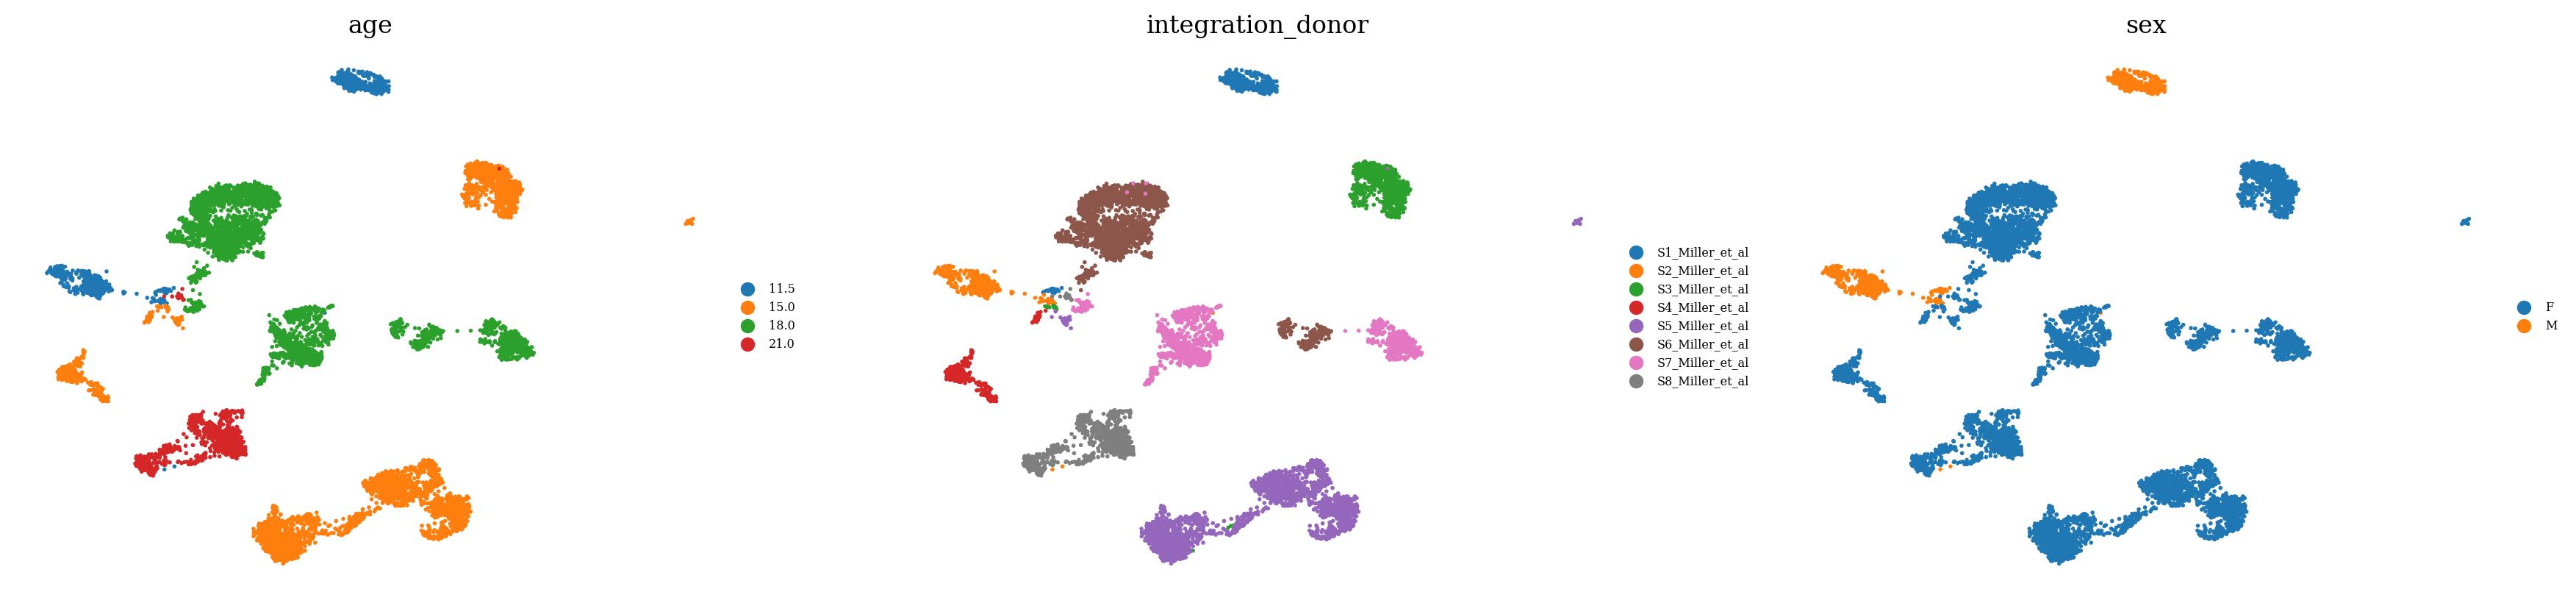

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

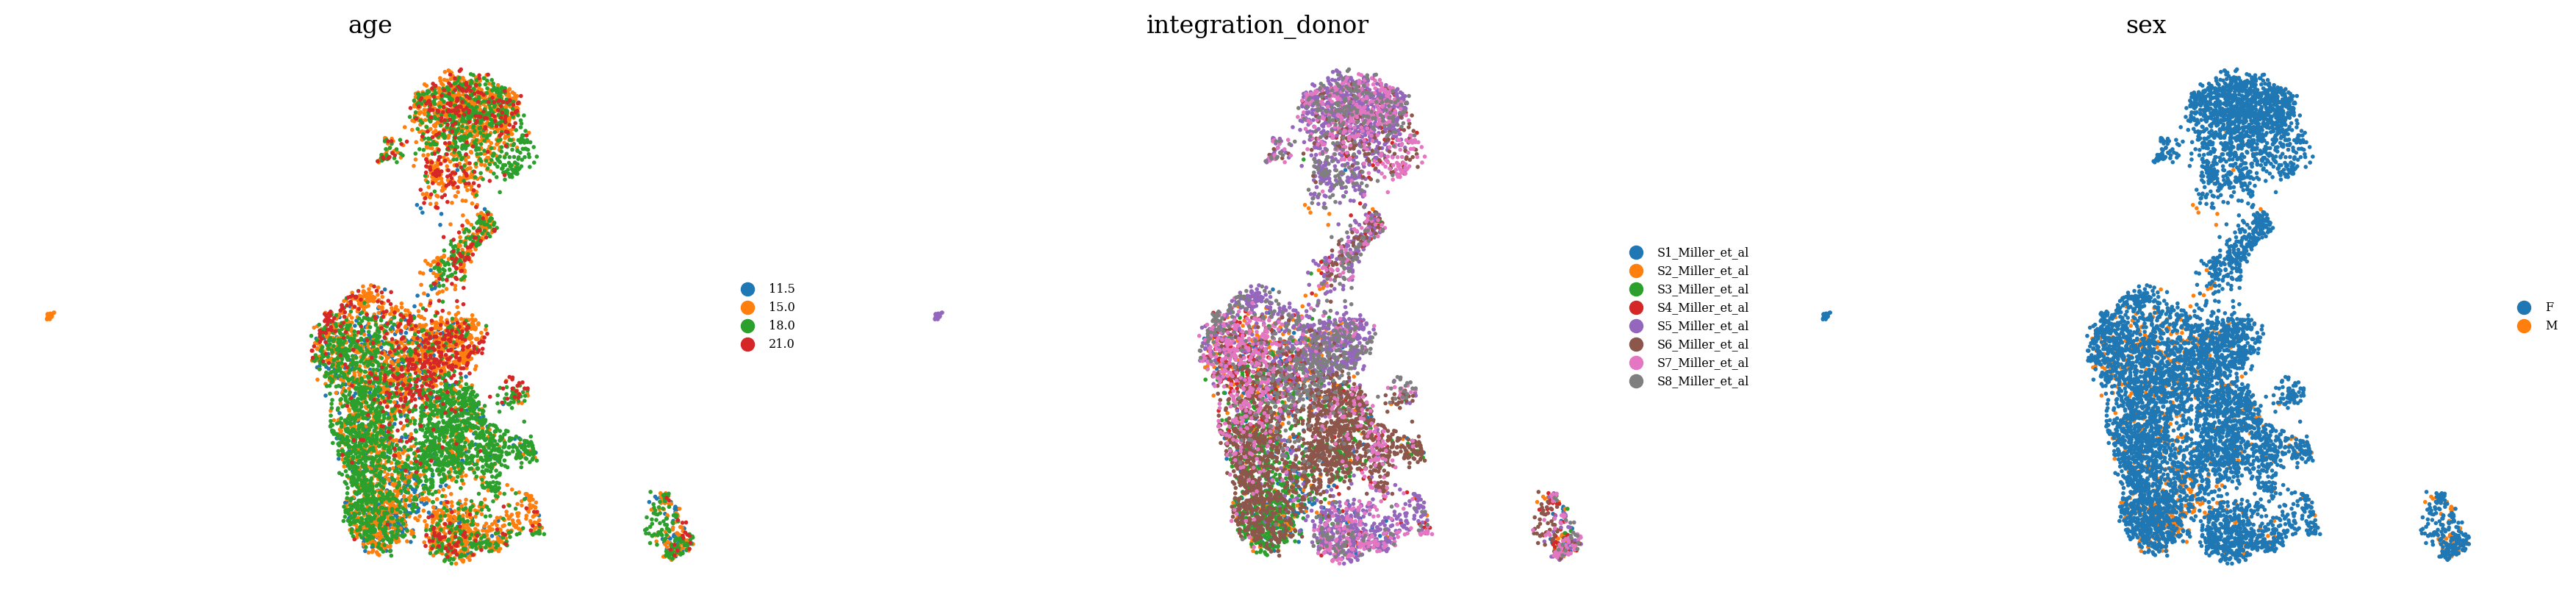

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  3%|▎         | 8/232 [00:00<00:02, 79.35it/s]

 12%|█▏        | 28/232 [00:00<00:01, 146.98it/s]

 21%|██        | 49/232 [00:00<00:01, 173.54it/s]

 29%|██▉       | 67/232 [00:00<00:01, 86.90it/s] 

 35%|███▍      | 81/232 [00:00<00:01, 97.35it/s]

 41%|████      | 95/232 [00:00<00:01, 106.18it/s]

 47%|████▋     | 109/232 [00:00<00:01, 113.31it/s]

 53%|█████▎    | 123/232 [00:01<00:00, 118.92it/s]

 59%|█████▉    | 137/232 [00:01<00:00, 123.06it/s]

 65%|██████▌   | 151/232 [00:01<00:00, 126.27it/s]

 71%|███████   | 165/232 [00:01<00:00, 128.57it/s]

 77%|███████▋  | 179/232 [00:01<00:00, 130.20it/s]

 83%|████████▎ | 193/232 [00:01<00:00, 131.12it/s]

 89%|████████▉ | 207/232 [00:01<00:00, 131.58it/s]

 95%|█████████▌| 221/232 [00:01<00:00, 131.43it/s]

100%|██████████| 232/232 [00:02<00:00, 113.76it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.6258127531493733

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)